In [1]:
import importlib
import sys
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')

from __init__ import *
from __init__jupyterlab import *
from scipy import sparse
import collections
import itertools
import re
import fbpca
import pickle
import scipy.cluster.hierarchy as sch
from sklearn.metrics import euclidean_distances

import snmcseq_utils
importlib.reload(snmcseq_utils)
import CEMBA_run_tsne
import CEMBA_clst_utils
import SCF_utils
importlib.reload(SCF_utils)

import seaborn as sns 
import matplotlib.pyplot as plt

# Configs  

In [2]:
name = 'mop_9mods_v2_corr_190722'
# name = 'mop_9mods_v2_corr_190702'
outdir = '/cndd/fangming/CEMBA/data/MOp_all/results'
output_pcX_all = outdir + '/pcX_all_{}.npy'.format(name)
output_cells_all = outdir + '/cells_all_{}.npy'.format(name)
output_imputed_data_format = outdir + '/imputed_data_{}_{{}}.npy'.format(name)
output_clst_and_umap = outdir + '/intg_summary_{}.tsv'.format(name)
output_figures = outdir + '/figures/{}_{{}}.{{}}'.format(name)
output_cluster_centroids = outdir + '/centroids_{}.pkl'.format(name)


In [3]:
DATA_DIR = '/cndd/fangming/CEMBA/data/MOp_all/organized_neurons_v7'

# fixed dataset configs
sys.path.insert(0, DATA_DIR)
import __init__datasets
importlib.reload(__init__datasets)
from __init__datasets import *

meta_f = os.path.join(DATA_DIR, '{0}_metadata.tsv')
hvftrs_f = os.path.join(DATA_DIR, '{0}_hvfeatures.{1}')
hvftrs_gene = os.path.join(DATA_DIR, '{0}_hvfeatures.gene')
hvftrs_cell = os.path.join(DATA_DIR, '{0}_hvfeatures.cell')

In [4]:
mods_selected = [
    'snmcseq_gene',
    'snatac_gene',
    'smarter_cells',
    'smarter_nuclei',
    '10x_cells', 
    '10x_nuclei', 
    '10x_cells_v3',
    '10x_nuclei_v3',
    '10x_nuclei_v3_Macosko',
    ]

features_selected = ['10x_cells']
# features_selected = ['smarter_cells']
# check features
for features_modality in features_selected:
    assert (features_modality in mods_selected)

# within modality
ps = {'mc': 0.9,
      'atac': 0.1,
      'rna': 0.7,
     }
drop_npcs = {'mc': 0,
      'atac': 0,
      'rna': 0,
     }

# across modality
cross_mod_distance_measure = 'correlation' # cca
knn = 20 
relaxation = 3
n_cca = 30

# PCA
npc = 50

# clustering
k = 30
resolutions = [0.8, 1, 2, 4]
# umap
umap_neighbors = 60
min_dist=min_dist = 0.5

## Read in data 

In [7]:
log = snmcseq_utils.create_logger()
logging.info('*')

07/23/2019 04:04:59 PM *


In [8]:
metas = collections.OrderedDict()
for mod in mods_selected:
    metas[mod] = pd.read_csv(meta_f.format(mod), sep="\t").reset_index().set_index(settings[mod].cell_col)
    print(mod, metas[mod].shape)

snmcseq_gene (4936, 38)
snatac_gene (17370, 27)
smarter_cells (6244, 11)
smarter_nuclei (5911, 11)
10x_cells (117688, 12)
10x_nuclei (77842, 12)
10x_cells_v3 (109853, 2)
10x_nuclei_v3 (39537, 2)
10x_nuclei_v3_Macosko (121131, 7)


In [9]:
gxc_hvftrs = collections.OrderedDict()
for mod in mods_selected:
    print(mod)
    ti = time.time()
    
    if settings[mod].mod_category == 'mc':
        f_mat = hvftrs_f.format(mod, 'tsv')
        gxc_hvftrs[mod] = pd.read_csv(f_mat, sep='\t', header=0, index_col=0) 
        gxc_hvftrs[mod].index = SCF_utils.standardize_gene_name(gxc_hvftrs[mod].index)  # standardize gene name 
        print(gxc_hvftrs[mod].shape, time.time()-ti)
        assert np.all(gxc_hvftrs[mod].columns.values == metas[mod].index.values) # make sure cell name is in the sanme order as metas (important if save knn mat)
        continue
        
        
    f_mat = hvftrs_f.format(mod, 'npz')
    f_gene = hvftrs_gene.format(mod)
    f_cell = hvftrs_cell.format(mod)
    _gxc_tmp = snmcseq_utils.load_gc_matrix(f_gene, f_cell, f_mat)
    _gene = _gxc_tmp.gene
    _cell = _gxc_tmp.cell
    _mat = _gxc_tmp.data

    _gene = SCF_utils.standardize_gene_name(_gene)  # standardize gene name  
    ## remove duplicated genes (for now)
    u, c = np.unique(_gene, return_counts=True)
    dup = u[c > 1]
    uniq_bool = np.array([False if gene in dup else True for gene in _gene])
    _gene_selected = _gene[uniq_bool]
    _gene_selected_idx = np.arange(len(_gene))[uniq_bool]
    _gene = _gene_selected
    _mat = _mat.tocsr()[_gene_selected_idx, :]
    ## remove duplicated genes complete
    
    gxc_hvftrs[mod] = GC_matrix(_gene, _cell, _mat)
    assert np.all(gxc_hvftrs[mod].cell == metas[mod].index.values) # make sure cell name is in the sanme order as metas (important if save knn mat)
    print(gxc_hvftrs[mod].data.shape, time.time()-ti)
    

snmcseq_gene
(4830, 4936) 8.255122184753418
snatac_gene
(6827, 17370) 1.565082311630249
smarter_cells
(4176, 6244) 1.238274097442627
smarter_nuclei
(3809, 5911) 0.7171387672424316
10x_cells
(4050, 117688) 17.188714504241943
10x_nuclei
(3521, 77842) 3.954061269760132
10x_cells_v3
(4662, 109853) 22.939549922943115
10x_nuclei_v3
(4212, 39537) 4.294675588607788
10x_nuclei_v3_Macosko
(4347, 121131) 17.912163734436035


## All done, making plots after 

- Plotting packages

In [10]:
f = output_clst_and_umap

df_info = pd.read_csv(f, sep="\t", index_col='sample') 
df_info = df_info.rename({
                          'tsne_x': 'tsne_x_joint',
                          'tsne_y': 'tsne_y_joint',
                         }, axis=1)
df_info['modality_name'] = df_info['modality'].apply(lambda mod: settings[mod].name)

# add cluster, annot info
df_info['cluster'] = ''
df_info['annot'] = ''
for mod in mods_selected:
    _cells = metas[mod].index.values
    df_info.loc[_cells, 'cluster'] = metas[mod].loc[_cells, settings[mod].cluster_col]
    df_info.loc[_cells, 'annot'] = metas[mod].loc[_cells, settings[mod].annot_col]

print(df_info.shape)
df_info.head()

(500512, 10)


,cluster_joint_r0.1,cluster_joint_r1,cluster_joint_r2,cluster_joint_r4,tsne_x_joint,tsne_y_joint,modality,modality_name,cluster,annot
sample,,,,,,,,,,
3C_M_0,2,10,34,16,2.425765,-10.595576,snmcseq_gene,DNA methylation,9,L2/3
3C_M_1,3,5,12,54,0.860791,4.660228,snmcseq_gene,DNA methylation,6,L5a
3C_M_2,1,14,10,28,9.347272,-8.134928,snmcseq_gene,DNA methylation,11,L4
3C_M_3,2,7,5,16,-2.208261,-10.176394,snmcseq_gene,DNA methylation,19,L2/3
3C_M_4,1,14,10,28,9.529292,-8.240075,snmcseq_gene,DNA methylation,11,L4


In [204]:
# clean up annotation
df_info['annot'] = df_info['annot'].str.replace('_Glutamatergic', '')
df_info['annot'] = df_info['annot'].str.replace('_GABAergic', '')
df_info['annot'] = df_info['annot'].fillna(df_info['cluster'])

In [10]:
set_matplotlib_formats('retina')

In [11]:
# gene by cell matrix 

mods_ordered = [
    'snmcseq_gene',
    'smarter_nuclei',
    'smarter_cells',
#     'snatac_gene',
#     '10x_nuclei', 
#     '10x_cells_v3',
#     '10x_nuclei_v3',
#     '10x_nuclei_v3_Macosko',
#     '10x_cells', 
    ]

n_gene_cum = []
n_cell_cum = []
n_genes = []
n_cells = []

n_gene_curr = 0
n_cell_curr = 0

mod_genes = {}
for mod in mods_ordered:
    if settings[mod].mod_category == 'mc':
        n_gene, n_cell = gxc_hvftrs[mod].shape
        mod_genes[mod] = gxc_hvftrs[mod].index.values 
    else:
        n_gene, n_cell = gxc_hvftrs[mod].data.shape
        mod_genes[mod] = gxc_hvftrs[mod].gene 
        
    n_gene_curr += n_gene
    n_cell_curr += n_cell
    n_gene_cum.append(n_gene_curr)
    n_cell_cum.append(n_cell_curr)
    n_genes.append(n_gene) 
    n_cells.append(n_cell) 
    
mod_names = {mod: settings[mod].name for mod in mods_ordered}

In [82]:
def plot_0():
    import matplotlib.patches as patches
    with sns.axes_style('ticks'):
        fig = plt.figure(figsize=(6,8))
        ax = fig.add_axes([0, 0, 0.7, 1]) 

        for n_gene in n_gene_cum:
            ax.axvline(n_gene, color='gray', linewidth=1)
        for n_cell in n_cell_cum:
            ax.axhline(n_cell, color='gray', linewidth=1)
        for i in range(len(mods_ordered)):
            if i == 0:
                left_x = 0
                left_y = 0
                length_x = n_gene_cum[i]
                length_y = n_cell_cum[i]
            else:
                left_x = n_gene_cum[i-1]
                left_y = n_cell_cum[i-1]
                length_x = n_gene_cum[i] - n_gene_cum[i-1]
                length_y = n_cell_cum[i] - n_cell_cum[i-1]

            # Add the patch to the Axes
            rect = patches.Rectangle((left_x, left_y), length_x, length_y, 
                                     linewidth=1, 
                                     edgecolor=None,
                                     facecolor=settings[mods_ordered[i]].color)
            ax.add_patch(rect)
            # Add y ticks
            ax.text(-500, 
                    left_y + 1.0/2*length_y,
                    n_cells[i],
                    ha='left',
                    va='center',
                   )
            # Add x ticks
            ax.text(left_x + 1.0/2*length_x,
                    n_cell_cum[-1] + 5000,
                    n_genes[i], rotation=90,
                    ha='center',
                    va='bottom',
                   )
        ax.set_facecolor('lightgray')

        ax.set_xlim([n_gene_cum[-1], 0]) # flip axies
        ax.set_xticks(n_gene_cum[:-1])
        ax.set_xticklabels([])
        ax.set_xlabel('Highly variable genes')

        ax.set_ylim([0, n_cell_cum[-1]])
        ax.set_yticks(n_cell_cum[:-1])
        ax.set_yticklabels([])
        ax.set_ylabel('Cells')
        ax.tick_params(top=True, right=True)

        # colorbar 
        cbar_ax = fig.add_axes([0.95, 0.2, 0.05, 0.6]) 
        ax = cbar_ax
        for i in range(len(mods_ordered)):

            # Add the patch to the Axes
            left_x, left_y = 0, i
            length_x, length_y = 1, 1
            rect = patches.Rectangle((left_x, left_y), length_x, length_y, 
                                     linewidth=1, 
                                     edgecolor=None,
                                     facecolor=settings[mods_ordered[i]].color)
            ax.add_patch(rect)

            # add labels
            ax.text(1.5, 
                    left_y + 1.0/2*length_y,
                    settings[mods_ordered[i]].name,
                    ha='left',
                    va='center',
                   )
        ax.set_xticks([]) 
        ax.set_yticks([]) 
        ax.set_xlim([0, 1])
        ax.set_ylim([0, len(mods_ordered)])

        fig.savefig(output_figures.format('001', 'pdf'), bbox_inches='tight')
        plt.show()

        
def plot_S0():
    n_genes_impute = pd.DataFrame(index=mods_ordered, columns=mods_ordered)
    for mod_x, mod_y in itertools.combinations(mods_ordered, 2):
        n = len(np.intersect1d(mod_genes[mod_x], mod_genes[mod_y]))
    #     n_genes_impute.loc[mod_x, mod_y] = n
        n_genes_impute.loc[mod_y, mod_x] = n

    fig, ax = plt.subplots(figsize=(6,4))
    sns.heatmap(n_genes_impute.fillna(np.nan).rename(index=mod_names, columns=mod_names),
                ax=ax, cmap='rocket_r', cbar_kws={'label': 'Intersection of\nhighly variable genes'})
    fig.savefig(output_figures.format('002', 'pdf'), bbox_inches='tight')
    plt.show()
    
def plot_1():
    from matplotlib.gridspec import GridSpec

    sample_n = min(len(df_info), 20000)
    n_resolutions = len(resolutions)
    with sns.plotting_context('talk'):
        fig = plt.figure(figsize=(8*2,6*2))
        gs = GridSpec(2, n_resolutions)

        ax = fig.add_subplot(gs[0, :])
        kw_colors = {settings[mod].name: settings[mod].color for mod in mods_ordered}
        tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'modality_name'
        legend_kws = {'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
        snmcseq_utils.plot_tsne_labels_ax(df_info, ax, tx, ty, tc, 
                                          legend_kws=legend_kws,
                                          kw_colors=kw_colors,
                                          sample_n=sample_n,
                                          legend_size=30,
                                          rasterized=True,
                                          s=2,
                                         )
        ax.set_aspect('equal')
        ax.axis('off')

        layouts = [(1, i) for i in range(n_resolutions)]
        for resolution, layout in zip(resolutions, layouts):
            ax = fig.add_subplot(gs[layout[0], layout[1]])
            tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'cluster_joint_r{}'.format(resolution)
            snmcseq_utils.plot_tsne_labels_ax(df_info, ax, tx, ty, tc, 
                                              legend_mode=-1,
                                              sample_n=sample_n,
                                              rasterized=True,
                                              s=2,
                                             )
            ax.set_aspect('equal')
            ax.axis('off')
            ax.set_title('{} joint clusters (r={})'.format(len(df_info[tc].unique()), resolution))

        fig.tight_layout()
        fig.savefig(output_figures.format(1, 'pdf'), bbox_inches='tight', dpi=300)
        plt.show()

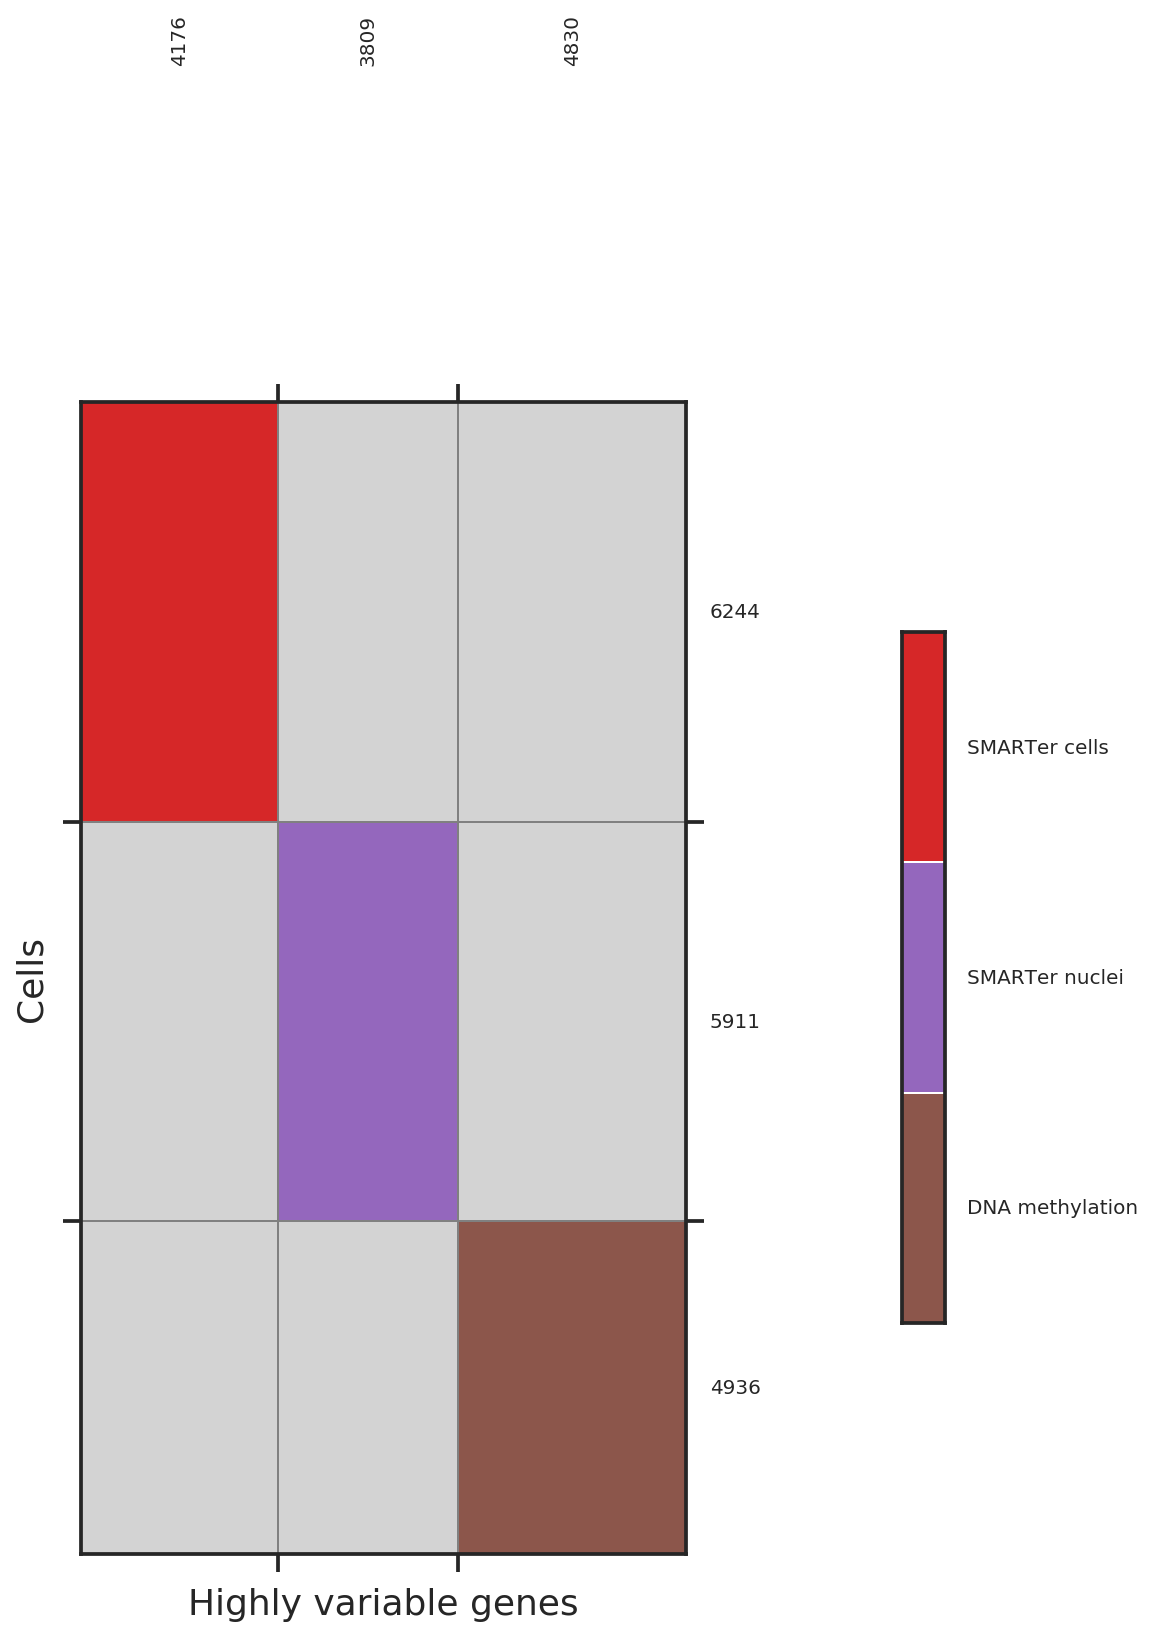

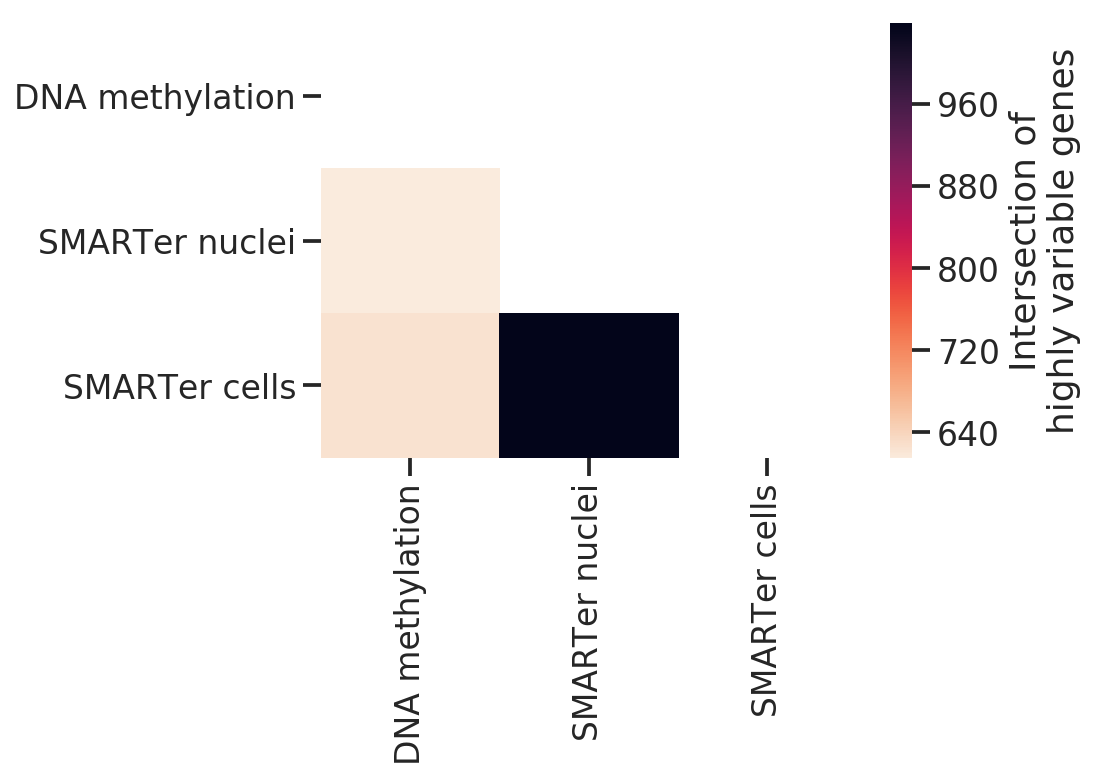

In [81]:
plot_0()
plot_S0()


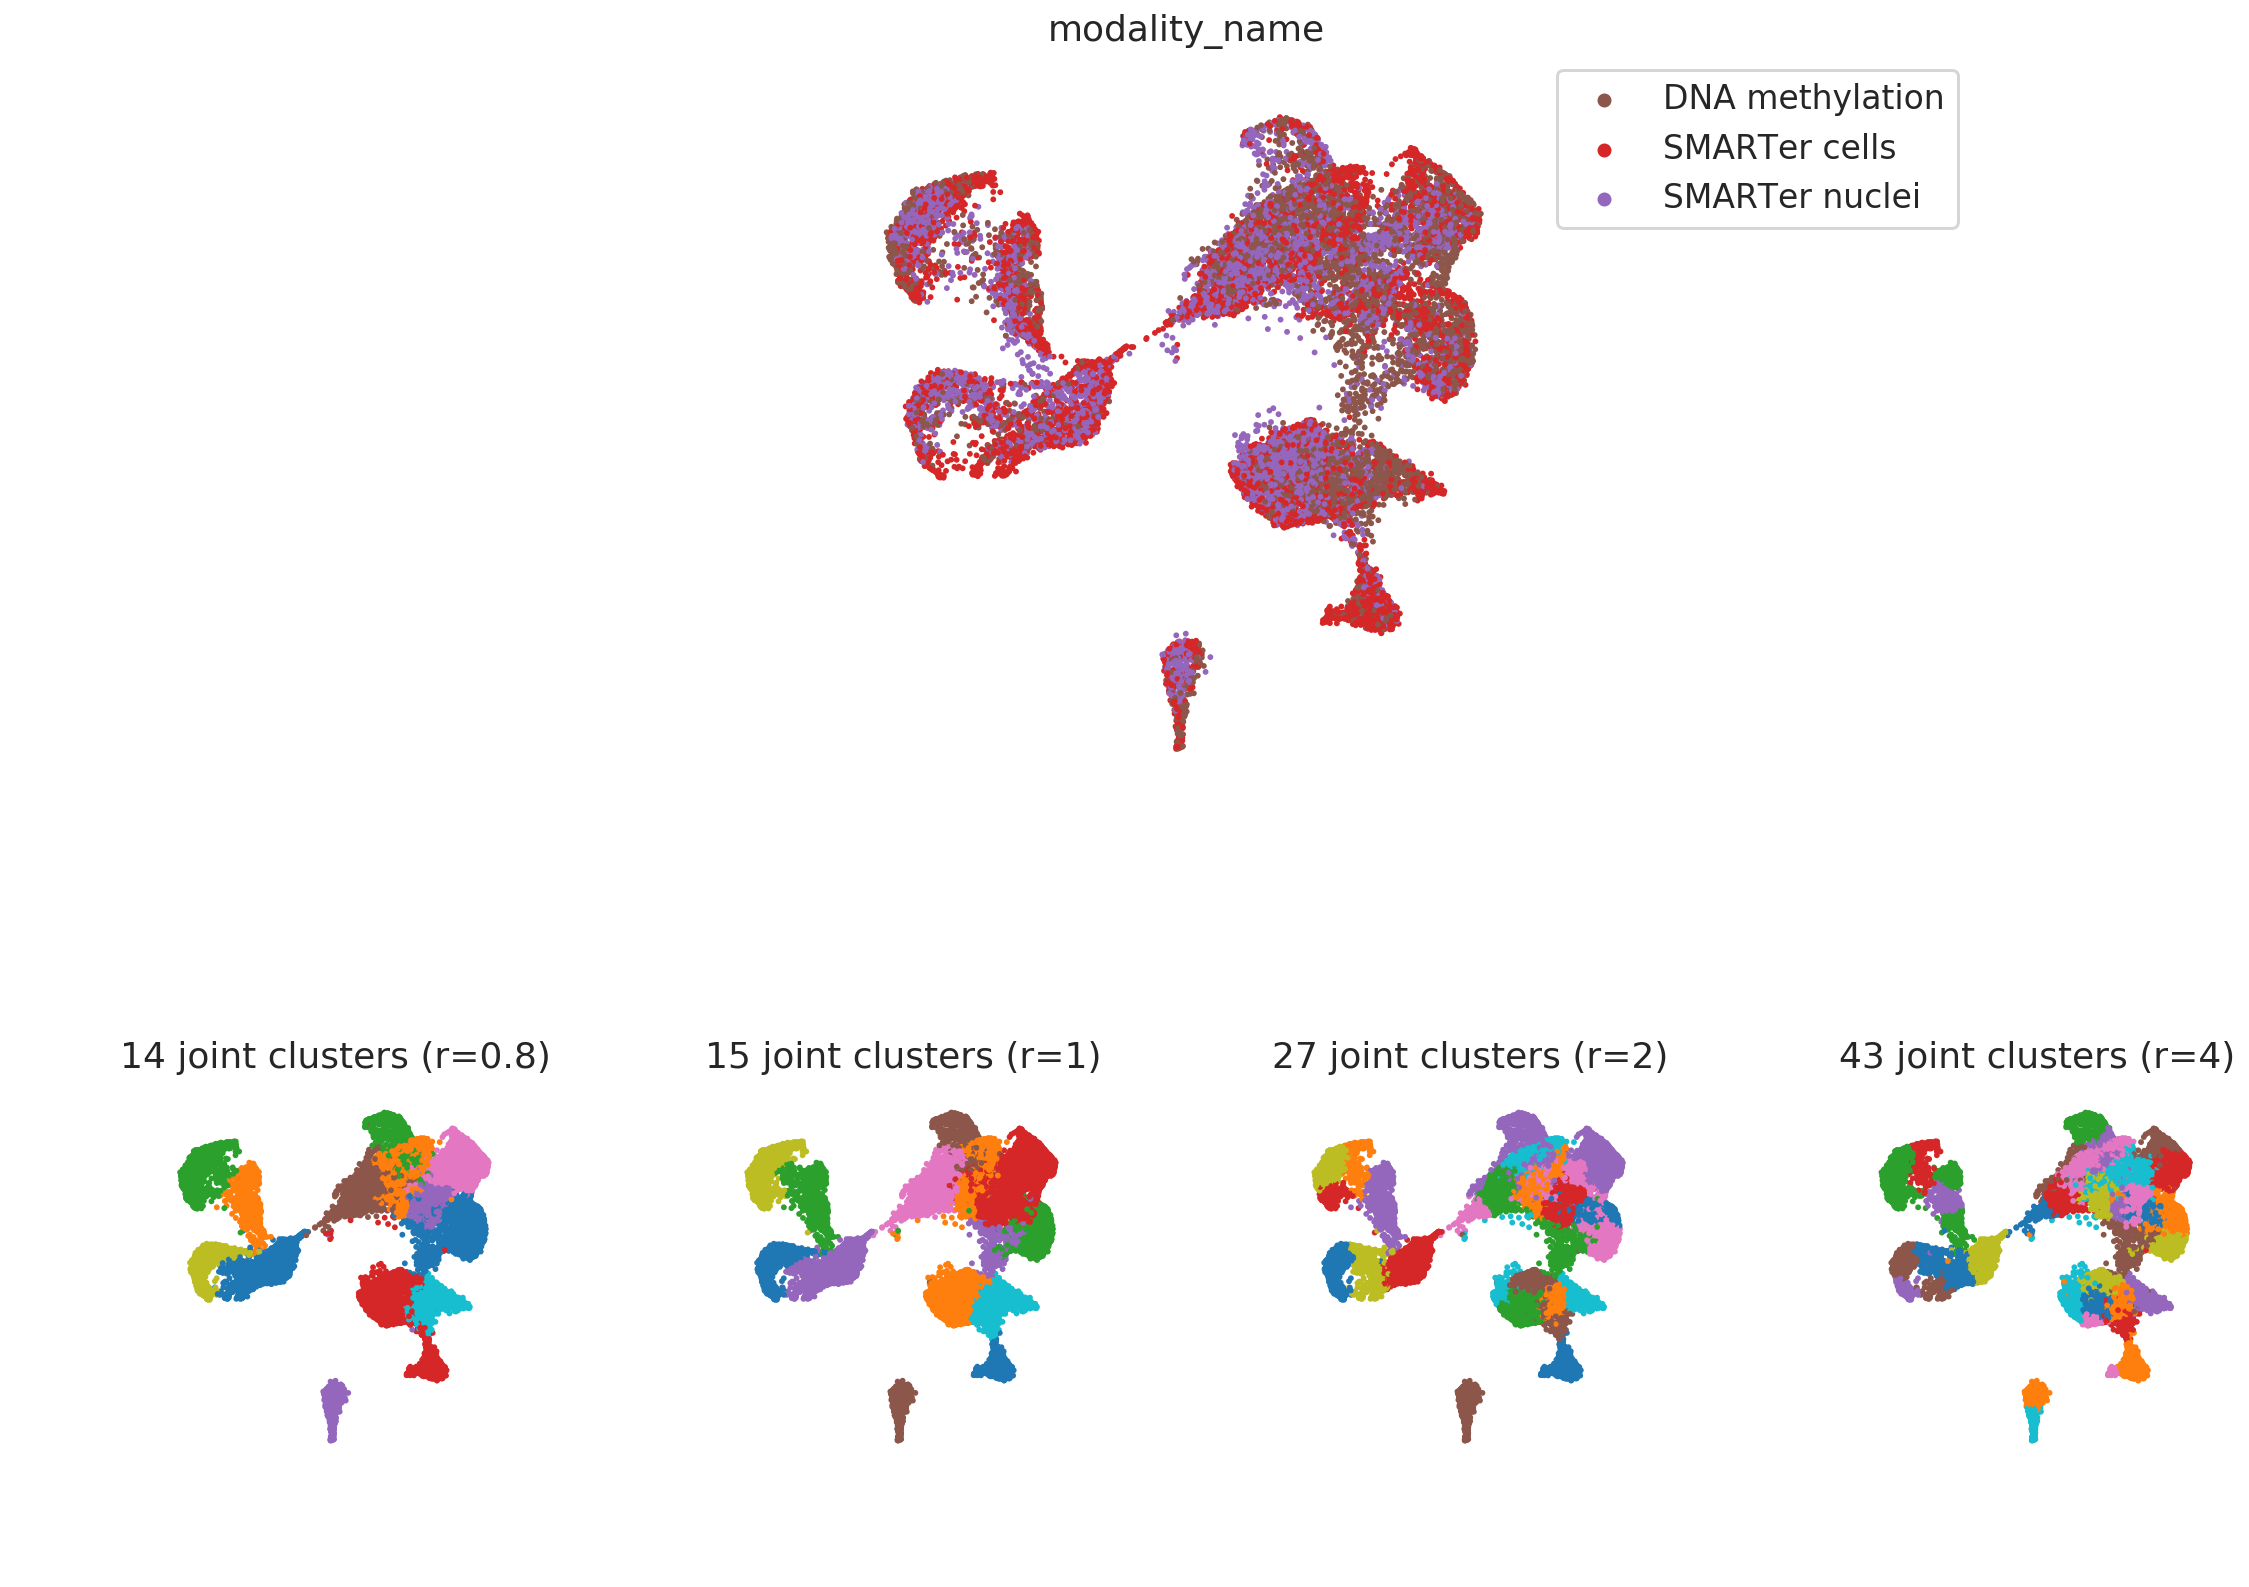

In [83]:
plot_1()

In [63]:
centroids = {}
_x = (df_info[['tsne_x_joint', 'tsne_y_joint', 'cluster', 'modality']]
             .groupby(['modality', 'cluster']).median())


for mod in mods_selected:
    centroids[mod] = _x.loc[mod, :]
centroids['joint'] = (df_info[['tsne_x_joint', 'tsne_y_joint', 'cluster_joint_r1']]
             .groupby(['cluster_joint_r1']).median())

In [97]:
def plot_1_single(label=False):
    with sns.plotting_context('talk'):
        fig, ax = plt.subplots(1, 1, figsize=(8*1,8*1))
        kw_colors = {settings[mod].name: settings[mod].color for mod in mods_selected}
        tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'cluster_joint_r1'
        legend_kws = {'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
        snmcseq_utils.plot_tsne_labels_ax(df_info, ax, tx, ty, tc, 
    #                                       legend_kws=legend_kws,
                                          sample_n=sample_n,
                                          legend_size=30,
                                          rasterized=True,
    #                                       kw_colors=kw_colors,
                                          legend_mode=-1,
                                          s=2,
                                         )
        ax.set_aspect('equal')
        ax.axis('off')

        fig.savefig(output_figures.format('1-nolabel', 'pdf'), bbox_inches='tight', dpi=300)
        plt.show()
        
def plot_2_single(label=False):
    with sns.plotting_context('talk'):
        fig, ax = plt.subplots(1, 1, figsize=(8*1,8*1))
        kw_colors = {settings[mod].name: settings[mod].color for mod in mods_selected}
        tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'modality_name'
        legend_kws = {'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
        snmcseq_utils.plot_tsne_labels_ax(df_info, ax, tx, ty, tc, 
                                          legend_kws=legend_kws,
                                          sample_n=sample_n,
                                          legend_size=30,
                                          rasterized=True,
                                          kw_colors=kw_colors,
                                          s=2,
                                         )
        ax.set_aspect('equal')
        ax.axis('off')

        fig.savefig(output_figures.format('2-nolabel', 'pdf'), bbox_inches='tight', dpi=300)
        plt.show()

def plot_3(show_labels=False):
    with sns.plotting_context('talk'):
        n = len(mods_selected)
        nx = 3
        ny = int((n+nx-1)/nx)
        fig, axs = plt.subplots(ny, nx, figsize=(6*nx,6*ny))
        axs = axs.flatten()
        tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'cluster'
    #     tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'annot'

        for ax, mod in zip(axs, mods_selected):
            snmcseq_utils.plot_tsne_labels_ax(df_info[df_info['modality']==mod], ax, tx, ty, tc, 
    #                                           legend_kws=legend_kws,
                                              sample_n=sample_n,
                                              legend_mode=-1,
                                              rasterized=True,
                                              s=2,
                                             )
            ax.set_title('{} ({} clusters)'.format(settings[mod].name, len(df_info.loc[df_info['modality']==mod, tc].unique())))
        
            if show_labels:
                for clst, centroid in centroids[mod].iterrows():
                    facecolor='white'
                    ax.text(centroid.values[0], 
                            centroid.values[1], 
                            clst,
                            color='black', 
                            bbox=dict(facecolor=facecolor, alpha=0.3, edgecolor='black', boxstyle='round,pad=0.1'),
                            fontsize=10,
                           )
            ax.set_aspect('equal')
            ax.axis('off')
        for ax in axs[n:]:
            ax.axis('off')


        fig.subplots_adjust(wspace=0.05, hspace=0.05)
        fig.savefig(output_figures.format('3-nolabel', 'pdf'), bbox_inches='tight', dpi=300)
        plt.show()


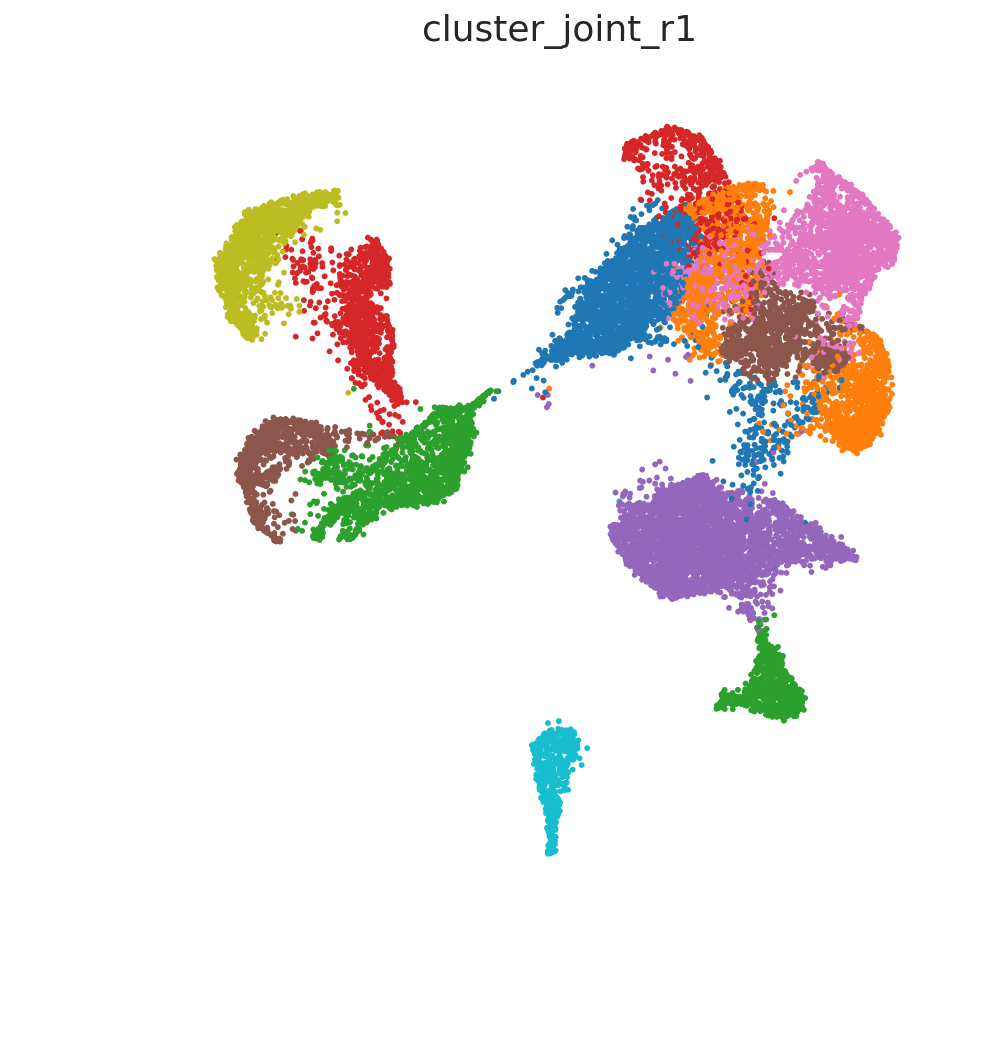

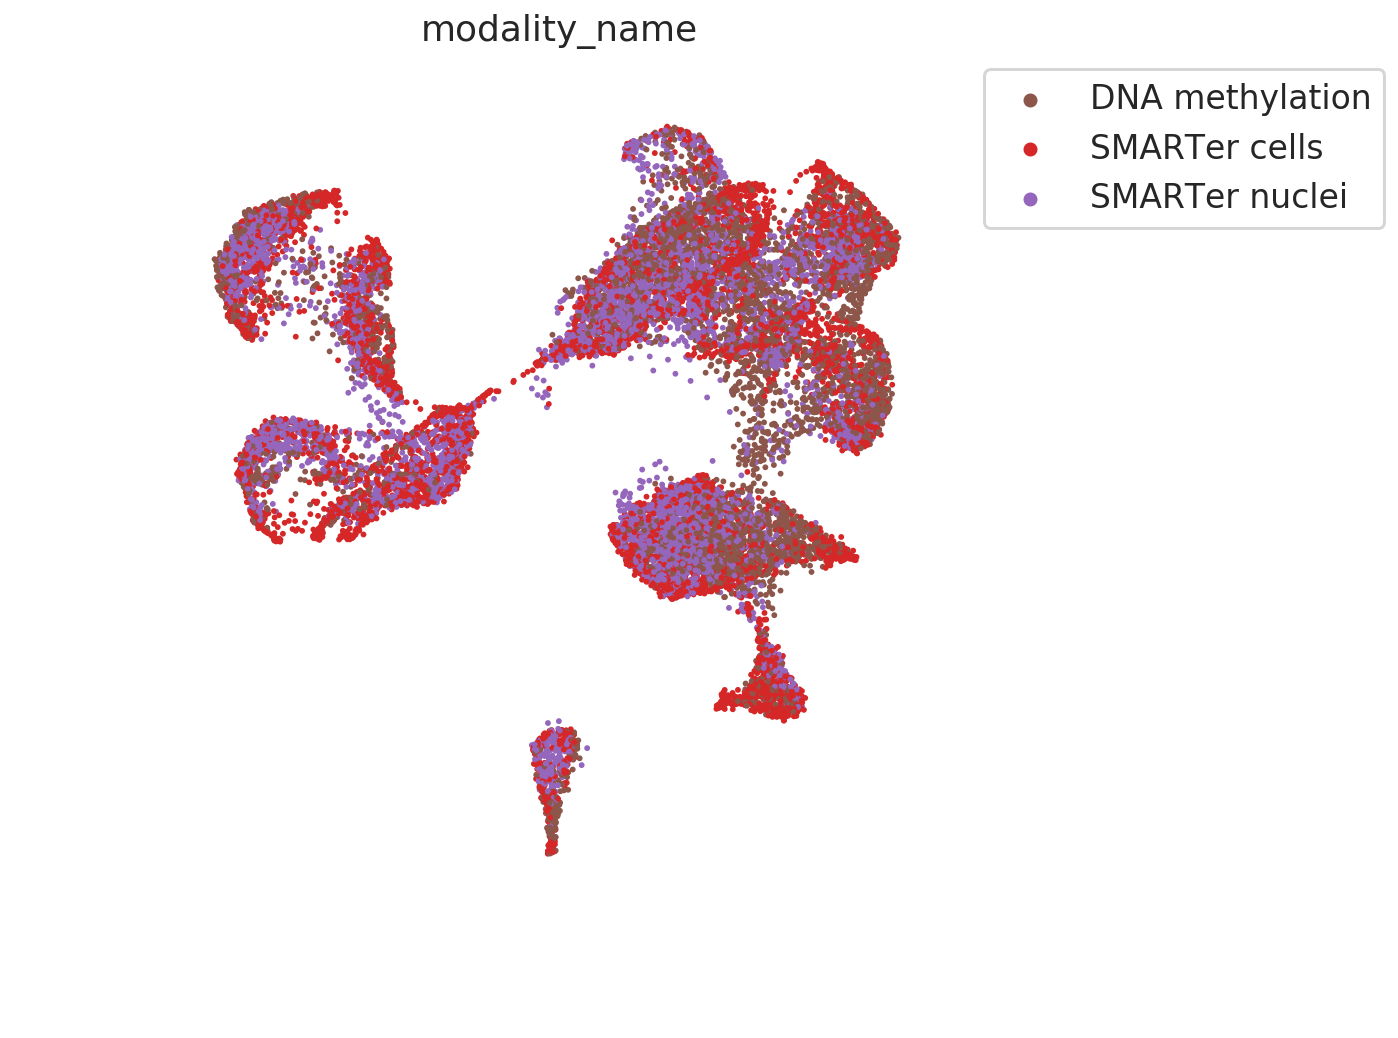

In [86]:
plot_1_single()
plot_2_single()

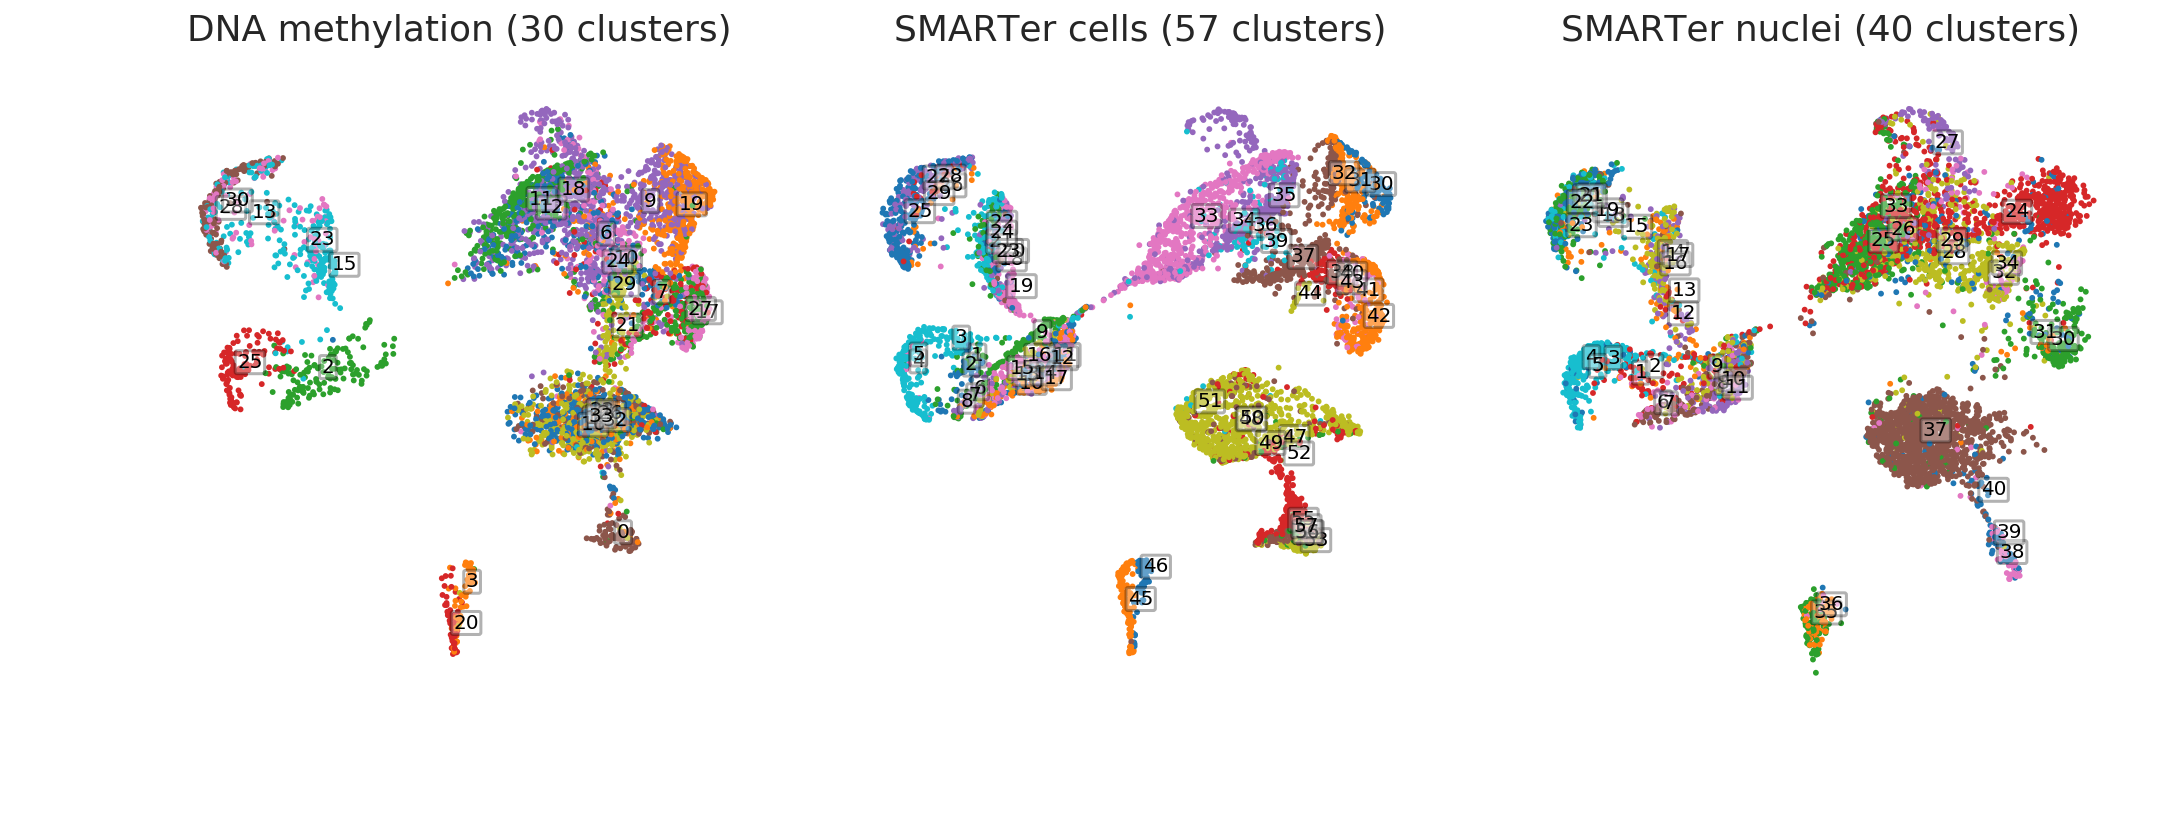

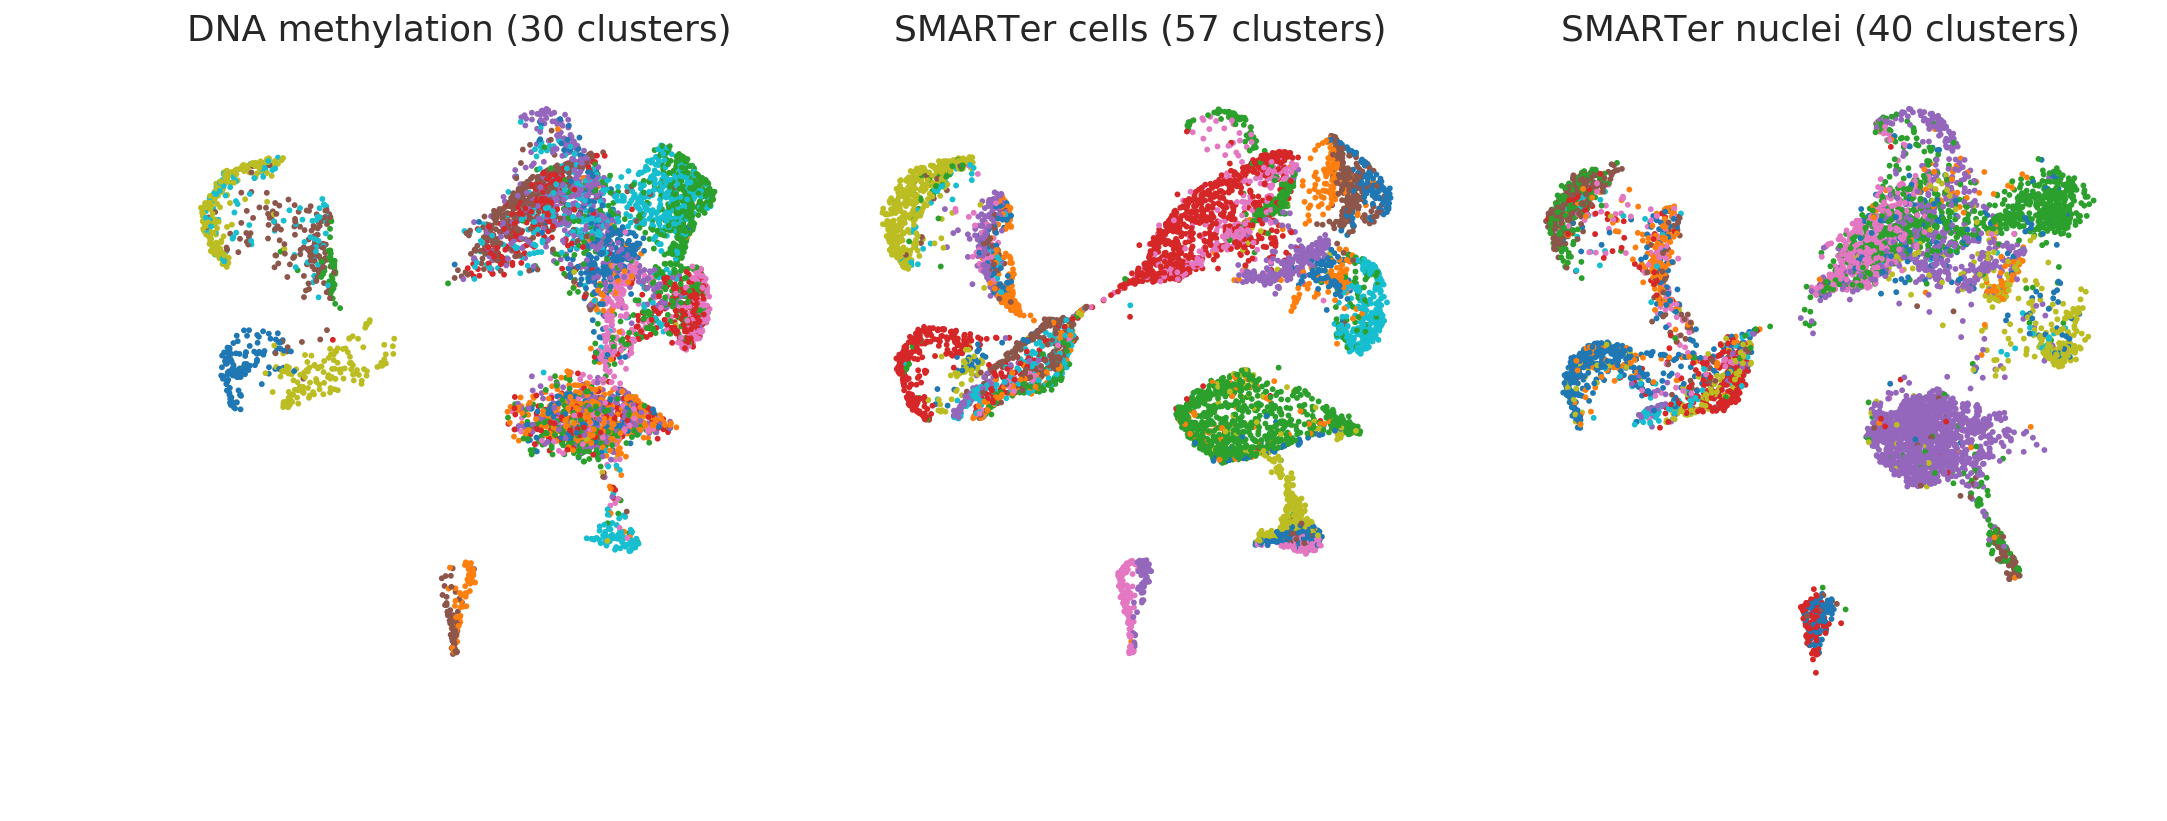

In [98]:
plot_3(show_labels=True)
plot_3(show_labels=False)

In [99]:
# Confusion matrix
# histograms
hist = df_info.groupby(['cluster_joint_r1', 'modality']).size().unstack().fillna(0).astype(int)
hist_mod = hist.sum(axis=0)
hist_clst = hist.sum(axis=1)

hist_frac = hist.divide(hist_clst, axis=0)
hist_exp = pd.DataFrame(np.outer(hist_clst/hist_clst.sum(), hist_mod), 
             index=hist_clst.index, columns=hist_mod.index.values)
hist_enrich = (hist+1)/(hist_exp+1)
hist_enrich.head()

modality,smarter_cells,smarter_nuclei,snmcseq_gene
cluster_joint_r1,,,
1,0.767577,1.503006,0.691710
2,0.743319,1.291326,0.975811
3,0.752130,0.939874,1.385411
4,1.461227,1.074539,0.327588
5,1.125071,1.065690,0.763244


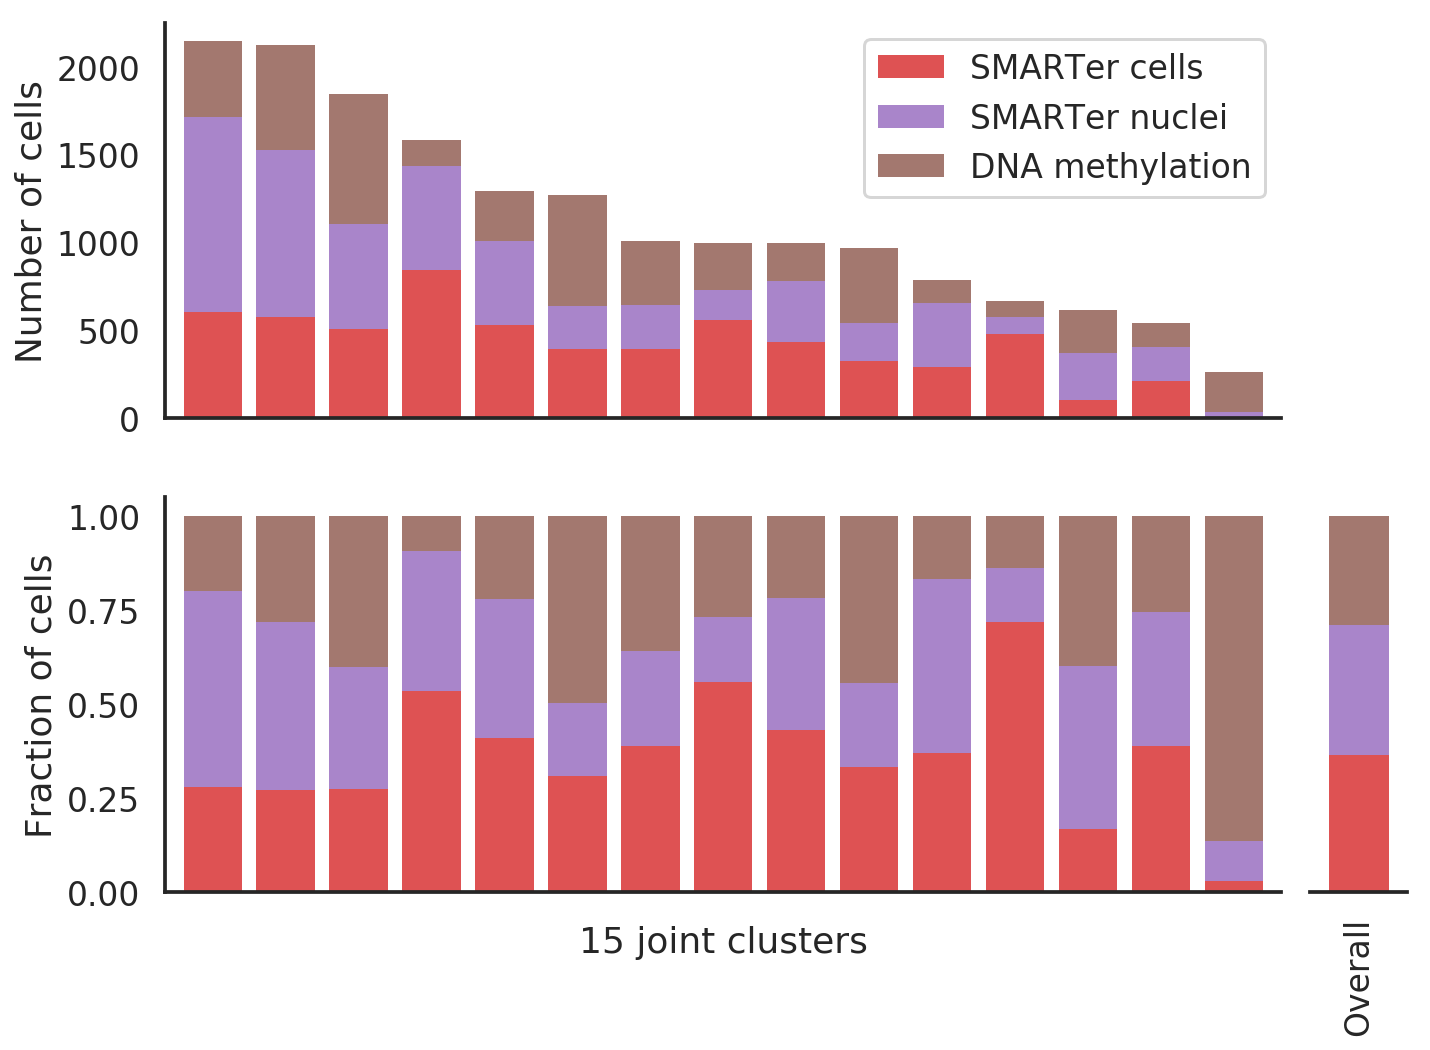

In [100]:
mod_colors = collections.OrderedDict({mod: settings[mod].color for mod in mods_ordered})

with sns.plotting_context('talk'), sns.axes_style('white', {"patch.edgecolor": "black", 'patch.force_edgecolor': False,}):
    # histograms
    fig, axs = plt.subplots(2, 1, figsize=(10,4*2))
    ax = axs[0]
    hist[mods_ordered[::-1]].rename(index=mod_names, columns=mod_names).plot.bar(stacked=True, width=0.8, alpha=0.8, ax=ax, 
                  color=[val for key, val in mod_colors.items()][::-1], # this controls mod_colors
                 )
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend(bbox_to_anchor=(1, 1))
    ax.set_ylabel('Number of cells')
    ax.set_xlabel('')
    ax.set_xticklabels([])
    

    ax = axs[1]
    hist_frac[mods_ordered[::-1]].rename(index=mod_names, columns=mod_names).plot.bar(stacked=True, width=0.8, alpha=0.8, ax=ax, legend=False, 
                  color=[val for key, val in mod_colors.items()][::-1], # this controls mod_colors
                 )
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel('Fraction of cells')
    ax.set_xlabel('{} joint clusters'.format(len(hist)))
    ax.set_xticklabels([])
    
#     ax = fig.add_axes([.95, .5, .05, .4])
    left_x, left_y, width, height = ax.get_position().bounds
    ax = fig.add_axes((left_x+width+0.2*(1-(left_x+width)), left_y, 0.3*(1-width), height))
    ((hist_mod/hist_mod.sum()).loc[mods_ordered[::-1]].to_frame().T.rename({0: 'Overall'}, axis=0)
                      .plot.bar(stacked=True, width=0.8, alpha=0.8, ax=ax, legend=False, 
                      color=[val for key, val in mod_colors.items()][::-1]) # this controls mod_colors
    )
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel('')
    ax.set_yticklabels([])
    
#     fig.tight_layout()
    fig.savefig(output_figures.format(4, 'pdf'), bbox_inches='tight')
    plt.show()

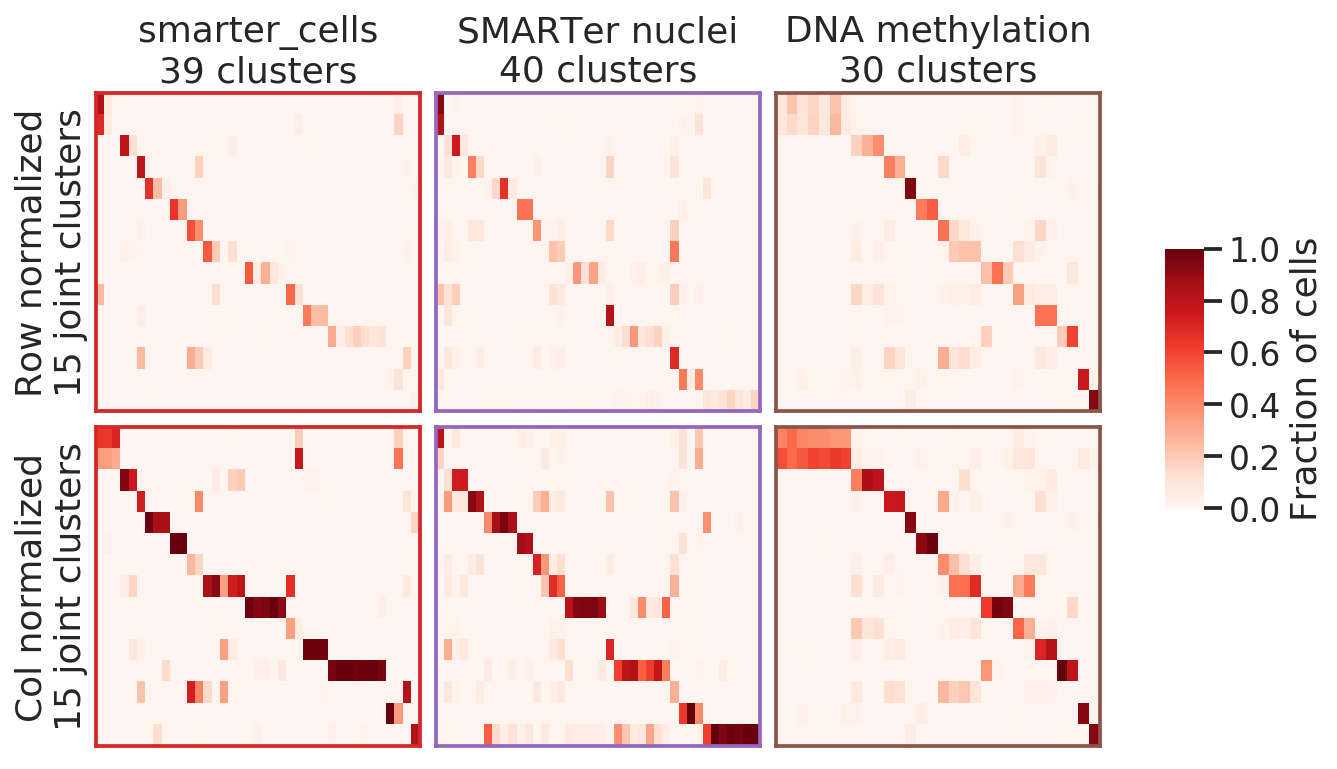

In [101]:
# confusion matrix

nx = len(mods_ordered)
ny = 2
heatmap_kws = {
    'xticklabels': False, 
    'yticklabels': False,
    'vmin': 0, 
    'vmax': 1,
    'cmap': 'Reds',
}

cbar_kws = {
    'orientation': 'vertical', 
    'label': 'Fraction of cells',
}

with sns.plotting_context('talk'):
    fig, axs = plt.subplots(ny, nx, figsize=(3*nx, 3*ny))
    axs = axs.T
    cbar_ax = fig.add_axes([0.95, 0.4, 0.03, 0.3])
    njoint_clusters = len(df_info['cluster_joint_r1'].unique())
    for i, (mod, ax) in enumerate(zip(mods_ordered[::-1], axs)):
        conf_mat = pd.crosstab(df_info.loc[df_info['modality']==mod, 'cluster'], 
                               df_info.loc[df_info['modality']==mod, 'cluster_joint_r1'],
                              )
        # normalize each joint cluster
        conf_mat_njoint = conf_mat.divide(conf_mat.sum(axis=0), axis=1)
        # normalize each orig cluster
        conf_mat_norig = conf_mat.divide(conf_mat.sum(axis=1), axis=0)

        # plot normalized by joint 
        if i == 0:
            # order both row and col
            _X = conf_mat_njoint
            _rX, ri, rc = snmcseq_utils.diag_matrix(_X.values, _X.index.values, _X.columns.values, threshold=0.3)
            _rX = pd.DataFrame(_rX, index=ri, columns=rc)
            g = sns.heatmap(_rX.T, 
                        cbar=True,
                        cbar_kws=cbar_kws,
                        cbar_ax=cbar_ax,
                        ax=ax[0],
                        **heatmap_kws,
                       )
            g.axes.set_title('{}\n{} clusters'.format(mod, _rX.shape[0]))
            g.axes.set_ylabel('Row normalized\n{} joint clusters'.format(njoint_clusters))

            order_joint = _rX.columns.values # Will be fixed for all integrated clusters 
            order_orig = _rX.index.values # Will be fixed for the mod clusters  
        else:
            # order just row (orig)
            _X = conf_mat_njoint.loc[:, order_joint].fillna(0)
            _rX, ri, rc = snmcseq_utils.diag_matrix_rows(_X.values, _X.index.values, _X.columns.values)
            _rX = pd.DataFrame(_rX, index=ri, columns=rc)
            g = sns.heatmap(_rX.T, 
                        cbar=False,
                        ax=ax[0],
                        **heatmap_kws,
                       )
            g.axes.set_title('{}\n{} clusters'.format(settings[mod].name, _rX.shape[0]))
            g.axes.set_ylabel('')

            order_orig = _rX.index.values # Will be fixed for the mod clusters  
        # bounding box
        for _, spine in g.axes.spines.items():
            spine.set_visible(True)
            spine.set_color(settings[mod].color)
#             spine.set_linewidth(3)

        # plot normalized by orig (according to the axis of normalized by joint) 
        _X = conf_mat_norig.loc[order_orig, order_joint].fillna(0)
        g = sns.heatmap(_X.T, 
                    cbar=False,
                    ax=ax[1],
                    **heatmap_kws,
                   )
        if i == 0:
            g.axes.set_xlabel('')
            g.axes.set_ylabel('Col normalized\n{} joint clusters'.format(njoint_clusters))
        else:
            g.axes.set_xlabel('')
            g.axes.set_ylabel('')
        # bounding box
        for _, spine in g.axes.spines.items():
            spine.set_visible(True)
            spine.set_color(settings[mod].color)
#             spine.set_linewidth(3)
            
    plt.subplots_adjust(hspace=0.05, wspace=0.05)
    fig.savefig(output_figures.format(5, 'pdf'), bbox_inches='tight')
    plt.show()

In [102]:
ftrs_f = os.path.join(DATA_DIR, '{0}_raw.{1}')
ftrs_gene = os.path.join(DATA_DIR, '{0}_raw.gene')
ftrs_cell = os.path.join(DATA_DIR, '{0}_raw.cell')

raw_f = os.path.join(DATA_DIR, '{0}_{1}raw.npz')
raw_gene = os.path.join(DATA_DIR, '{0}_raw.gene')
raw_cell = os.path.join(DATA_DIR, '{0}_raw.cell')

gxc_ftrs = collections.OrderedDict()
for mod in mods_selected:
    print(mod)
    ti = time.time()
    
    if settings[mod].mod_category == 'mc':
        _mat_c = sparse.load_npz(raw_f.format(mod, 'CH_')) 
        _mat_mc = sparse.load_npz(raw_f.format(mod, 'mCH_')) 
        _gene = pd.read_csv(raw_gene.format(mod), sep='\t', header=None).iloc[:, 0].values #gene_name
        _gene = SCF_utils.standardize_gene_name(_gene)
        _cell = pd.read_csv(raw_cell.format(mod), sep='\t', header=None).iloc[:, 0].values 
        gxc_raw = GC_matrix(_gene, _cell, 
                                  {'c': _mat_c, 'mc': _mat_mc})
        
        base_call_cutoff = 20
        sufficient_coverage_fraction = 0.95
        # select genes covered (20 counts) in > 95% of cells
        n_gene, n_cell = gxc_raw.data['c'].shape
        gene_cov = (gxc_raw.data['c'] > base_call_cutoff).sum(axis=1)
        gene_cov = np.array(gene_cov).squeeze()/n_cell # fraction of cells covered
        cond = gene_cov>sufficient_coverage_fraction
        
        # to full matrix
        df_c = pd.DataFrame(
            gxc_raw.data['c'].tocsr()[cond, :].todense(),
            index=np.array(gxc_raw.gene)[cond],
            columns=gxc_raw.cell,
        )
        df_mc = pd.DataFrame(
            gxc_raw.data['mc'].tocsr()[cond, :].todense(),
            index=np.array(gxc_raw.gene)[cond],
            columns=gxc_raw.cell,
        )

        # compute normalized methylation matrix 
        df_mcc = snmcseq_utils.get_mcc_lite_v2(df_c, df_mc, base_call_cutoff=base_call_cutoff)
        gxc_ftrs[mod] = df_mcc.divide(metas[mod].loc[df_mcc.columns.values, 'mCH'], axis=1)
        del df_c, df_mc, df_mcc
        
        print(gxc_ftrs[mod].shape, time.time()-ti)
        continue
        
    f_mat = raw_f.format(mod, '')
    f_gene = raw_gene.format(mod)
    f_cell = raw_cell.format(mod)
    
    _mat = sparse.load_npz(f_mat) 
    _gene = pd.read_csv(f_gene, sep='\t', header=None).iloc[:, 0].values
    _gene = SCF_utils.standardize_gene_name(_gene)  # standardize gene name  
    _cell = pd.read_csv(f_cell, sep='\t', header=None).iloc[:, 0].values 
    
    gxc_raw = GC_matrix(_gene, _cell, _mat)
    gxc_ftrs[mod] = snmcseq_utils.sparse_logcpm(gxc_raw, mode='logcpm')
    
    del gxc_raw, _mat
    print(gxc_ftrs[mod].data.shape, time.time()-ti)
    

snmcseq_gene


07/22/2019 03:35:22 PM (16102, 4936)


(16102, 4936) 51.004770278930664
smarter_cells
(23017, 6244) 6.422757148742676
smarter_nuclei
(23017, 5911) 3.1415743827819824


In [103]:
sample_n = 5000

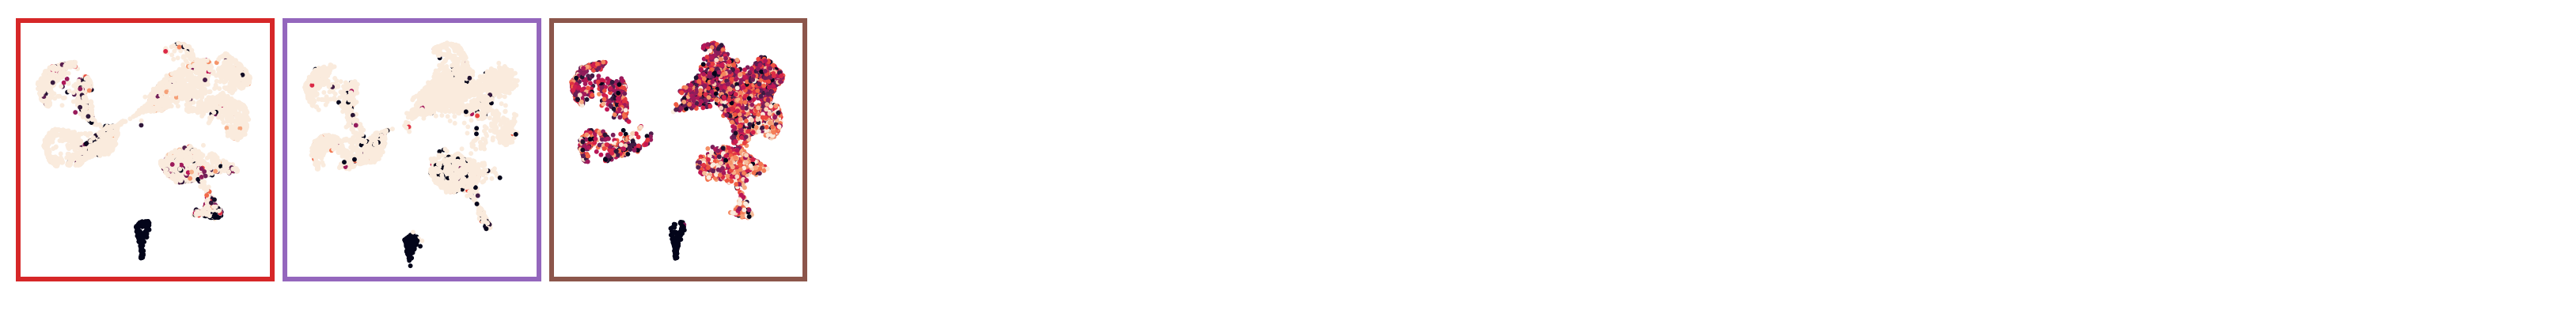

In [104]:
genes_inq = [
    'Tshz2',
#     'Bcl6', 
#     'Slco2a1', 
#     'Hpgd', 
#     'Npsr1', 
#     'Tshz2',
]
    
    
with sns.plotting_context('talk'), sns.axes_style('white'):
    n = len(mods_ordered)
    nx = 9
    ny = int((n+nx-1)/nx)
    fig, axs = plt.subplots(ny, nx, figsize=(3*nx,3*ny))
    axs = axs.flatten()
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', genes_inq[0]
    
    cbar_ax = fig.add_axes([0.9, 0.2, 0.05, 0.6])
    
    for i, (ax, mod) in enumerate(zip(axs, mods_ordered[::-1])):
        if settings[mod].mod_category == 'mc':
            genes = gxc_ftrs[mod].index.values
            uniq_gene_idx = pd.Series(genes).reset_index().groupby(0).first().sort_values('index')['index'].values
            gene_idx = uniq_gene_idx[snmcseq_utils.get_index_from_array(genes[uniq_gene_idx], genes_inq)]
#             gene_idx = snmcseq_utils.get_index_from_array(genes, genes_inq)
            gene_data = gxc_ftrs[mod].iloc[gene_idx].T
            # normalize gene_data
        else:
            genes = gxc_ftrs[mod].gene
            cells = gxc_ftrs[mod].cell
            uniq_gene_idx = pd.Series(genes).reset_index().groupby(0).first().sort_values('index')['index'].values
            gene_idx = uniq_gene_idx[snmcseq_utils.get_index_from_array(genes[uniq_gene_idx], genes_inq)]
#             gene_idx = snmcseq_utils.get_index_from_array(genes, genes_inq)
            gene_data = np.ravel(gxc_ftrs[mod].data.tocsr()[gene_idx, :].todense())
            gene_data = pd.Series(gene_data, index=cells).to_frame(genes_inq[0])
            # normalize gene_data
            gene_data = gene_data.applymap(lambda x: np.log10(x+1))
        
        # normalize gene_data
        gene_data = settings[mod].mod_direction*(gene_data - gene_data.mean())/gene_data.std()

        df_mod = df_info[df_info['modality']==mod]
        if sample_n > len(df_mod):
            df_plot = pd.merge(gene_data, df_mod, left_index=True, right_index=True)
        else:
            df_plot = (pd.merge(gene_data, df_mod, left_index=True, right_index=True)
                         .sample(sample_n, replace=False)
                      )
    
        if i == 0: 
            cbar = False
        else:
            cbar = False
        snmcseq_utils.plot_tsne_values_ax(df_plot, ax, tx, ty, tc, 
                                          s=2,
                                          cbar=cbar,
                                          cbar_ax=cbar_ax,
                                          cmap='rocket_r',
                                          rasterized=True,
                                         )
#         ax.set_title('{} '.format(settings[mod].name, ))
        ax.set_title('')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('auto')
        
        for _, spine in ax.spines.items():
            spine.set_color(settings[mod].color)
            spine.set_linewidth(3)
        
    for ax in axs[n:]:
        ax.axis('off')
    cbar_ax.axis('off')
        
    
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    fig.savefig(output_figures.format('6_{}'.format(genes_inq[0]), 'pdf'), bbox_inches='tight')
    plt.show()
    

In [105]:
genes_inq = [
    'Snap25',
    
    'Satb2',
    'Camk2a',
    'Tbr1',
    
    'Gad1',
    'Gad2',
    'Slc6a1',
    
    'Cux1',
    'Cux2',
    'Rorb',
    'Deptor',
    'Vat1l',
    'Sulf1',
    'Tle4',
    'Foxp2',
    'Grik3',
    'Bcl6',
    'Tshz2', 
    
    'Lhx6',
    'Adarb2',
    
    'Pvalb',
    'Sox6',
    'Gria1',
    
    'Prox1',
    'Sv2c',
    
    ]
clsts_uniq = np.sort(np.unique(df_info['cluster_joint_r1']))

df_plots = {} 
for i, (ax, mod) in enumerate(zip(axs, mods_ordered[::-1])):
    if settings[mod].mod_category == 'mc':
        genes = gxc_ftrs[mod].index.values
#         gene_idx = snmcseq_utils.get_index_from_array(genes, genes_inq)
        uniq_gene_idx = pd.Series(genes).reset_index().groupby(0).first().sort_values('index')['index'].values
        gene_idx = uniq_gene_idx[snmcseq_utils.get_index_from_array(genes[uniq_gene_idx], genes_inq)]
        gene_idx = gene_idx[gene_idx!=-1] # remove -1
        gene_data = gxc_ftrs[mod].iloc[gene_idx].T
        # normalize gene_data
    else:
        genes = gxc_ftrs[mod].gene
        cells = gxc_ftrs[mod].cell
#         gene_idx = snmcseq_utils.get_index_from_array(genes, genes_inq)
        uniq_gene_idx = pd.Series(genes).reset_index().groupby(0).first().sort_values('index')['index'].values
        gene_idx = uniq_gene_idx[snmcseq_utils.get_index_from_array(genes[uniq_gene_idx], genes_inq)]
        gene_idx = gene_idx[gene_idx!=-1] # remove -1
        gene_data = gxc_ftrs[mod].data.tocsr()[gene_idx, :].todense().T
        gene_data = pd.DataFrame(gene_data, index=cells, columns=genes_inq)
        # normalize gene_data
        gene_data = gene_data.applymap(lambda x: np.log10(x+1))
    
    
    df_mod = df_info.loc[df_info['modality']==mod, ['cluster_joint_r1']]
    if sample_n > len(df_mod):
        df_plot = pd.merge(gene_data, df_mod, left_index=True, right_index=True)
    else:
        df_plot = (pd.merge(gene_data, df_mod, left_index=True, right_index=True)
                     .sample(sample_n, replace=False)
                  )
    df_plot = df_plot.groupby('cluster_joint_r1').mean()
    
    # normalize gene_data
#     df_plot = settings[mod].mod_direction*(df_plot - df_plot.mean(axis=0))/df_plot.std(axis=0)
    df_plot = settings[mod].mod_direction*df_plot
    df_plots[mod] = df_plot.T.reindex(
                                    index=genes_inq, 
                                    columns=clsts_uniq,
                                    )

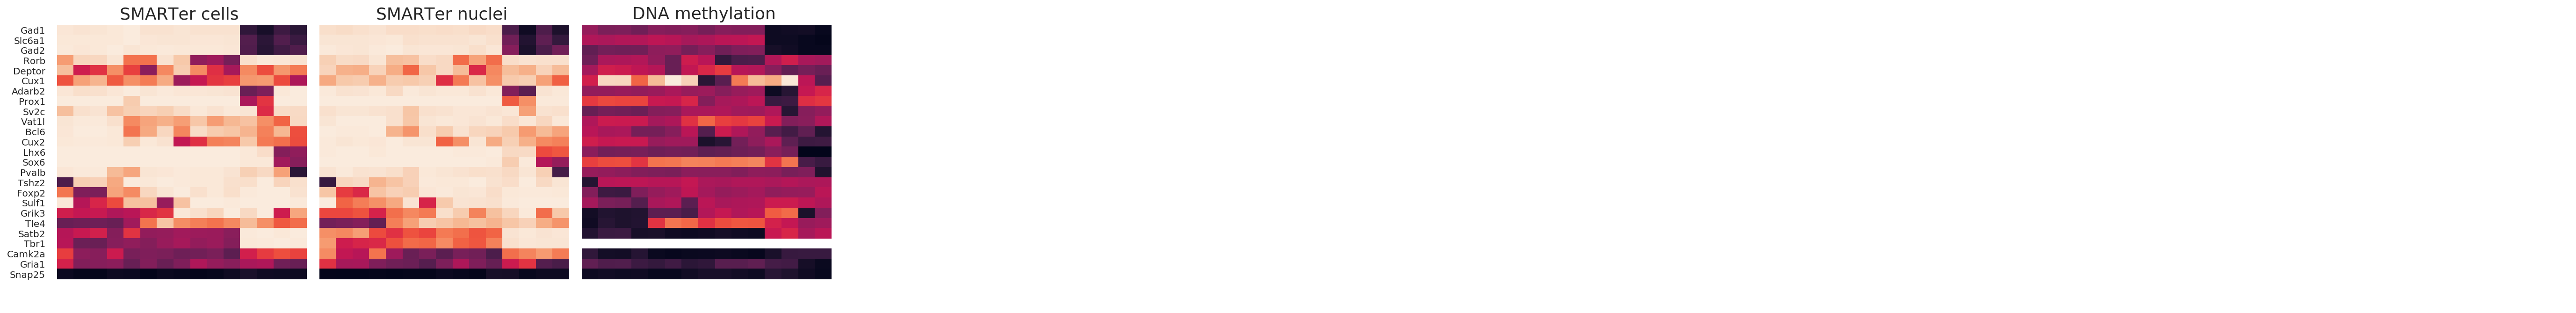

In [106]:
import scipy.cluster.hierarchy as sch
with sns.plotting_context('talk'), sns.axes_style('white'):
    n = len(mods_ordered)
    nx = 9
    ny = int((n+nx-1)/nx)
    fig, axs = plt.subplots(ny, nx, figsize=(5*nx,5*ny))
    axs = axs.flatten()
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', genes_inq[0]
    cbar_ax = fig.add_axes([0.9, 0.2, 0.05, 0.6])
    
    for i, (ax, mod) in enumerate(zip(axs, mods_ordered[::-1])):
        if i == 0: 
            cbar = False
            # row gene
            Z = sch.linkage(df_plots[mod], method='average', metric='euclidean', optimal_ordering=True)
            dn = sch.dendrogram(Z, no_plot=True)['leaves']
            # col clst
            Z = sch.linkage(df_plots[mod].T, method='average', metric='euclidean', optimal_ordering=True)
            dn_clst = sch.dendrogram(Z, no_plot=True)['leaves']
        else:
            cbar = False
            
        sns.heatmap(df_plots[mod].iloc[dn, dn_clst], ax=ax, 
                                     cbar=cbar,
                                    yticklabels=True,
                                     cbar_ax=cbar_ax,
                                     cmap='rocket_r',
                                     )
        ax.set_title('{} '.format(settings[mod].name, ))
        ax.set_xticks([])
        
        if i == 0:
            ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
        else:
            ax.set_yticks([])
        ax.set_xlabel('')
            
        ax.set_aspect('auto')
        
        for _, spine in ax.spines.items():
            spine.set_color(settings[mod].color)
            spine.set_linewidth(3)
        
    for ax in axs[n:]:
        ax.axis('off')
    cbar_ax.axis('off')
        
    
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    fig.savefig(output_figures.format('7_gene_heatmap', 'pdf'), bbox_inches='tight')
    plt.show()
    

#### Heatmap of correlation of cluster centroids 
- imputed data

In [208]:
# mods_included = ['snmcseq_gene', 
#                  'smarter_nuclei',
#                  'smarter_cells',
#                 ]
# mod_reference = 'smarter_cells'
mods_included = mods_selected
mod_reference = features_selected[0]

joint_annot = df_info.groupby(['cluster_joint_r1']).agg({'annot': lambda x: x.value_counts().index.values[0]})
cells_all = np.load(output_cells_all)
imputed_data = np.load(output_imputed_data_format.format(mod_reference))


ti = time.time()
cluster_centroids = collections.OrderedDict()
for (clst, mod), df_sub in df_info.groupby(['cluster_joint_r1', 'modality']):
    if mod in mods_included:
        cells_sub = df_sub.index.values
        cells_sub_idx = snmcseq_utils.get_index_from_array(cells_all, cells_sub)
        if mod not in cluster_centroids.keys():
            cluster_centroids[mod] = {}
        cluster_centroids[mod][clst] = np.ravel(imputed_data[cells_sub_idx,:].mean(axis=0))

# print(cluster_centroids)
print(time.time()-ti)

44.27438521385193


In [167]:
# Saving the objects:
with open(output_cluster_centroids, 'wb') as f: 
    pickle.dump((
                cluster_centroids
                ), f)

In [209]:

cluster_centroids_df = collections.OrderedDict()
for mod in mods_selected:
    if mod in mods_included:
        cluster_centroids_df[mod] = pd.DataFrame(cluster_centroids[mod])

uniq_clusters = df_info['cluster_joint_r1'].unique()
corr_grand_clusters = np.hstack([[mod+'_'+str(clst)
                                for clst in cluster_centroids_df[mod].columns.values]
                                for mod in mods_included])

corr_grand = {}
for i, mod_x in enumerate(mods_included):
    for j, mod_y in enumerate(mods_included):
        if j >= i:
            gene_x = cluster_centroids_df[mod_x].index.values
            gene_y = cluster_centroids_df[mod_y].index.values
            gene_common = np.intersect1d(gene_x, gene_y)
            _x = (cluster_centroids_df[mod_x].loc[gene_common]).rank(axis=0).T.values
            _y = (cluster_centroids_df[mod_y].loc[gene_common]).rank(axis=0).T.values
            corr = np.corrcoef(_x, _y)[:len(_x), len(_x):]
            corr_grand[(i, j)] = corr
            if j != i:
                corr_grand[(j, i)] = corr.T
                
corr_grand = np.hstack([np.vstack([
                    corr_grand[(i, j)] for i in range(len(mods_included))
                    ])
                for j in range(len(mods_included))
                ])

corr_grand_label = np.hstack([[str(clst) + "_" + str(joint_annot.loc[clst, 'annot'])
                               for clst in cluster_centroids_df[mod].columns.values] 
                            for mod in mods_included
                            ])
corr_grand_clsts = np.hstack([cluster_centroids_df[mod].columns.values
                            for mod in mods_included
                            ])
corr_grand_mods = np.hstack([
                            [mod]*len(cluster_centroids_df[mod].columns.values) for mod in mods_included
                            ])

clsts = np.sort(df_info['cluster_joint_r1'].unique())
clst_colors = snmcseq_utils.gen_colors(len(clsts)) 
clst_colors = {clst: color for clst, color in zip(clsts, clst_colors)}

corr_grand_mod_colors = np.array([settings[mod].color for mod in corr_grand_mods])
corr_grand_clst_colors = np.array([clst_colors[clst] for clst in corr_grand_clsts])

In [212]:
joint_annot = df_info[df_info['modality']=='10x_cells'].groupby(['cluster_joint_r1']).agg({'annot': lambda x: x.value_counts().index.values[0]})


corr_grand_label = np.hstack([[str(clst) + "_" + str(joint_annot.loc[clst, 'annot'])
                               for clst in cluster_centroids_df[mod].columns.values] 
                            for mod in mods_included
                            ])
corr_grand_clsts = np.hstack([cluster_centroids_df[mod].columns.values
                            for mod in mods_included
                            ])
corr_grand_mods = np.hstack([
                            [mod]*len(cluster_centroids_df[mod].columns.values) for mod in mods_included
                            ])

clsts = np.sort(df_info['cluster_joint_r1'].unique())
clst_colors = snmcseq_utils.gen_colors(len(clsts)) 
clst_colors = {clst: color for clst, color in zip(clsts, clst_colors)}

corr_grand_mod_colors = np.array([settings[mod].color for mod in corr_grand_mods])
corr_grand_clst_colors = np.array([clst_colors[clst] for clst in corr_grand_clsts])

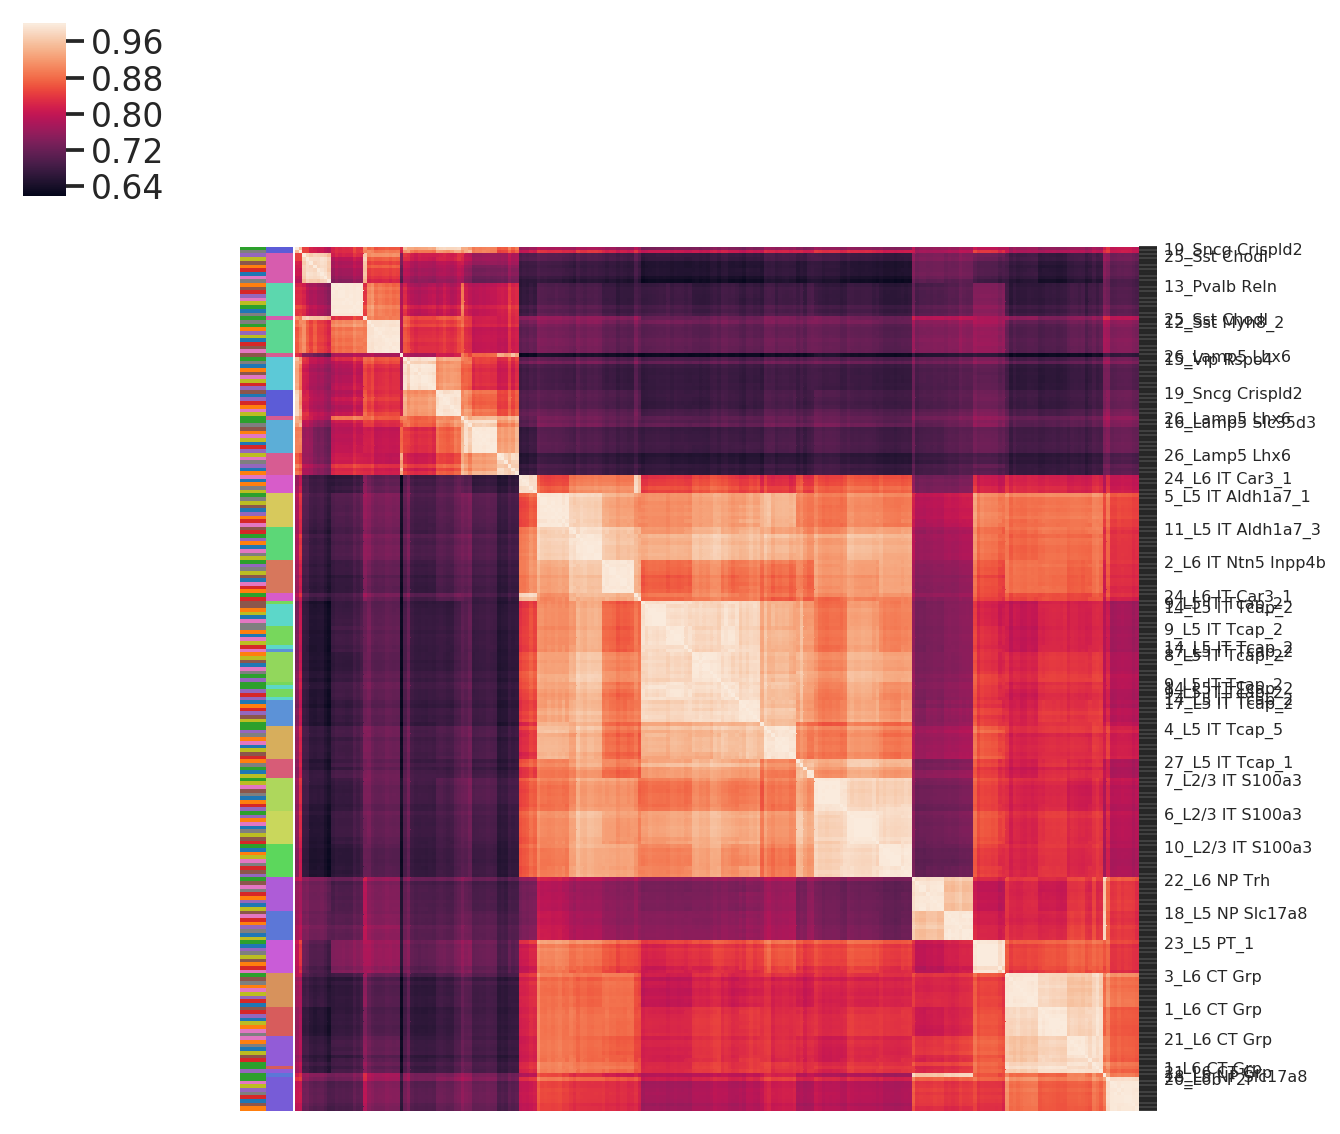

In [215]:
mat = corr_grand
Z = sch.linkage(mat, method='average')
dn = sch.dendrogram(Z, no_plot=True)

g = sns.clustermap(mat[dn['leaves'],:][:,dn['leaves']], 
                   row_cluster=False, col_cluster=False,
                   row_colors=[corr_grand_mod_colors[dn['leaves']], 
                               corr_grand_clst_colors[dn['leaves']], 
                              ], 
                   yticklabels=snmcseq_utils.dedup_array_elements(corr_grand_label[dn['leaves']]),
                   xticklabels=[],
#                    figsize=(8, 12),
                  )
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize=8)
g.savefig(output_figures.format('8_cluster_heatmap', 'pdf'), bbox_inches='tight')
plt.show()

#### Sextual dimorphism? 

In [14]:

# fig, ax = plt.subplots(1, 1, figsize=(8*1,8*1))
# # kw_colors = {settings[mod].name: settings[mod].color for mod in mods_selected}
# tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'cluster_joint_r1'
# legend_kws = {'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
# snmcseq_utils.plot_tsne_labels_ax(df_info, ax, tx, ty, tc, 
#                                     legend_kws=legend_kws,
#                                   sample_n=sample_n,
#                                   legend_size=30,
#                                   rasterized=True,
#                                   legend_mode=-1,
#                                   s=2,
#                                  )
# ax.set_aspect('equal')
# ax.axis('off')

# fig.savefig(output_figures.format('sex', 'pdf'), bbox_inches='tight', dpi=300)
# plt.show()



(3710, 18)


,donor_id,donor_sex,dissection_region,amp_name,amp_date,amp_pcr_cycles,library_name,library_date,library_pcr_cycles,library_pass_fail_call,library_cells_loaded,library_cells_recovered,sequencing_batch,sequencing_tube_barcode,sequencing_tube_mean_reads,sequencing_tube_median_genes,sequencing_tube_median_umi,sequencing_tube_saturation
sample_id,,,,,,,,,,,,,,,,,,
AAAGATGCAGGTTTCA-1L8TX_171026_01_F03,352353,Male,M1,A8TX_171019_01_A01,10/19/2017,10,L8TX_171026_01_F03,10/26/2017,11,Pass,9880,9805,RTX-808,SQ-80030-01,93502,4659,13426,0.7
AAAGTAGCACGTCAGC-1L8TX_171026_01_F03,352353,Male,M1,A8TX_171019_01_A01,10/19/2017,10,L8TX_171026_01_F03,10/26/2017,11,Pass,9880,9805,RTX-808,SQ-80030-01,93502,4659,13426,0.7
AAAGTAGTCGGTCTAA-1L8TX_171026_01_F03,352353,Male,M1,A8TX_171019_01_A01,10/19/2017,10,L8TX_171026_01_F03,10/26/2017,11,Pass,9880,9805,RTX-808,SQ-80030-01,93502,4659,13426,0.7
AACCATGAGTGTACCT-1L8TX_171026_01_F03,352353,Male,M1,A8TX_171019_01_A01,10/19/2017,10,L8TX_171026_01_F03,10/26/2017,11,Pass,9880,9805,RTX-808,SQ-80030-01,93502,4659,13426,0.7
AACCATGTCATTGCCC-1L8TX_171026_01_F03,352353,Male,M1,A8TX_171019_01_A01,10/19/2017,10,L8TX_171026_01_F03,10/26/2017,11,Pass,9880,9805,RTX-808,SQ-80030-01,93502,4659,13426,0.7


In [83]:
f = '/cndd/fangming/CEMBA/data/MOp_all/dropbox/smarter_cells/sample_metadata.csv'        
extra_meta = pd.read_csv(f, index_col=0)
f = '/cndd/fangming/CEMBA/data/MOp_all/dropbox/smarter_cells/cluster.membership.csv'        
extra_meta = extra_meta.join(pd.read_csv(f, index_col=0))
f = '/cndd/fangming/CEMBA/data/MOp_all/dropbox/smarter_cells/tsne.df.csv'        
extra_meta = extra_meta.join(pd.read_csv(f, index_col=0))
# f = '/cndd/fangming/CEMBA/data/MOp_all/dropbox/smarter_cells/cluster.annotation.csv'        
# extra_meta = extra_meta.join(pd.read_csv(f, index_col=0))

print(extra_meta.shape)
print(list(extra_meta.columns))
extra_meta.head()

(6300, 126)
['ar_id', 'exp_component_vendor_name', 'batch', 'batch_vendor_name', 'tube', 'tube_internal_name', 'tube_contents_nm', 'tube_contents_nm_from_vendor', 'tube_avg_size_bp', 'tube_input_fmol', 'r1_index', 'r2_index', 'index_sequence_pair', 'organism', 'facs_container', 'sample_name', 'patched_cell_container', 'cell_name', 'cell_id', 'sample_quantity_count', 'sample_quantity_pg', 'external_donor_name', 'gender', 'control', 'cell_prep_type', 'full_genotype', 'facs_population_plan', 'cre_line', 'reporter', 'injection_roi', 'injection_materials', 'roi', 'patchseq_roi', 'medical_conditions', 'slice_min_pos', 'slice_max_pos', 'rna_amplification_set', 'rna_amplification', 'amp_date', 'pcr_cycles', 'percent_cdna_longer_than_400bp', 'rna_amplification_pass_fail', 'amplified_quantity_ng', 'library_prep_set', 'library_prep', 'lib_date', 'library_input_ng', 'avg_size_bp', 'quantification2_ng', 'quantification_fmol', 'quantification2_nm', 'library_prep_pass_fail', 'exp_cluster_density_thou

,ar_id,exp_component_vendor_name,batch,batch_vendor_name,tube,tube_internal_name,tube_contents_nm,tube_contents_nm_from_vendor,tube_avg_size_bp,tube_input_fmol,...,percent_reads_aligned_to_trna_rmsk,percent_reads_aligned_to_ncrna,percent_reads_aligned_to_introns,percent_reads_aligned_to_intergenic,percent_reads_aligned_unique,x,Lim1,Lim2,cl,cl_label
LS-15395_S41_E1-50,543183476,LS-15395-41,R8S4-160812,RSC-035,LS-15395,R8S4-16081206,4.619923,7.578116,529,10,...,NaN,15.162980,9.855384,3.264771,84.993663,19,13.941554,-60.842948,14.0,Sst Myh8
LS-15395_S42_E1-50,543183474,LS-15395-42,R8S4-160812,RSC-035,LS-15395,R8S4-16081206,4.619923,7.578116,529,10,...,NaN,16.281620,6.763949,2.856108,87.252036,19,16.128240,-61.557862,14.0,Sst Myh8
LS-15395_S43_E1-50,543183472,LS-15395-43,R8S4-160812,RSC-035,LS-15395,R8S4-16081206,4.619923,7.578116,529,10,...,NaN,14.448787,13.283785,4.473082,84.439773,46,46.059443,-27.008051,40.0,L6 NP Trh
LS-15395_S44_E1-50,543183470,LS-15395-44,R8S4-160812,RSC-035,LS-15395,R8S4-16081206,4.619923,7.578116,529,10,...,NaN,16.687114,7.724415,3.083142,87.400895,45,62.750210,-11.826374,39.0,L5 NP Slc17a8
LS-15395_S46_E1-50,543183466,LS-15395-46,R8S4-160812,RSC-035,LS-15395,R8S4-16081206,4.619923,7.578116,529,10,...,NaN,15.844740,8.100115,3.478772,85.846808,38,-29.130415,20.139500,32.0,L5 IT Aldh1a7_2


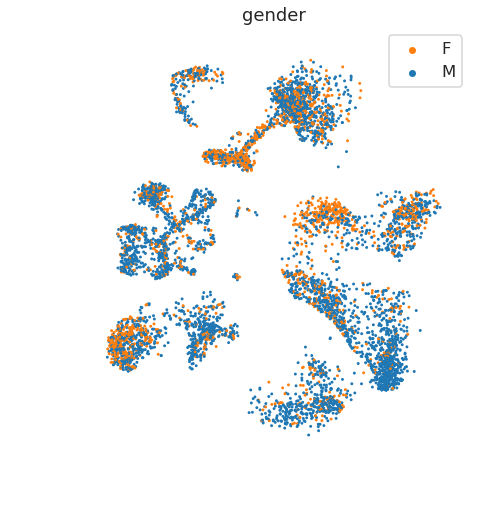

In [84]:
sample_n = 20000

fig, ax = plt.subplots(1, 1, figsize=(8*1,8*1))
# kw_colors = {settings[mod].name: settings[mod].color for mod in mods_selected}
tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'gender'
legend_kws = {'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
snmcseq_utils.plot_tsne_labels_ax(extra_meta.join(df_info)[[tx, ty, tc]].dropna(axis=0), ax, tx, ty, tc, 
#                                   legend_kws=legend_kws,
                                  sample_n=sample_n,
                                  legend_size=30,
                                  rasterized=True,
                                  s=2,
                                 )
ax.set_aspect('equal')
ax.axis('off')

# fig.savefig(output_figures.format('sex', 'pdf'), bbox_inches='tight', dpi=300)
plt.show()



In [88]:
f = '/cndd/fangming/CEMBA/data/MOp_all/dropbox/smarter_nuclei/sample_metadata.csv'        
extra_meta = pd.read_csv(f, index_col=0)
f = '/cndd/fangming/CEMBA/data/MOp_all/dropbox/smarter_nuclei/cluster.membership.csv'        
extra_meta = extra_meta.join(pd.read_csv(f, index_col=0))
f = '/cndd/fangming/CEMBA/data/MOp_all/dropbox/smarter_nuclei/tsne.df.csv'        
extra_meta = extra_meta.join(pd.read_csv(f, index_col=0))
# f = '/cndd/fangming/CEMBA/data/MOp_all/dropbox/smarter_nuclei/cluster.annotation.csv'        
# extra_meta = extra_meta.join(pd.read_csv(f, index_col=0))

print(extra_meta.shape)
extra_meta.head()

(6278, 145)


/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (61) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ar_id,exp_component_vendor_name,batch,batch_vendor_name,tube,tube_internal_name,tube_contents_nm,tube_contents_nm_from_vendor,tube_avg_size_bp,tube_input_fmol,...,cluster_label.2,category_label,Region.1,size,gene.counts,cluster_color,cluster_id,x,Lim1,Lim2
SM-GE653_S113_E1-50,647869537,SM-GE653-S113,R8S4-171101,RSC-127,SM-GE653,R8S4-17110107,8.03,3.17,379,8,...,Vip Htr1f,GABAergic,Cortex,53,7792,#FF4DC1,14,2,-11.010077,52.046985
SM-GE653_S114_E1-50,647869535,SM-GE653-S114,R8S4-171101,RSC-127,SM-GE653,R8S4-17110107,8.03,3.17,379,8,...,Lamp5 Pdlim5,GABAergic,Cortex,82,8502,#FF7290,3,4,-30.340635,52.757690
SM-GE653_S115_E1-50,647869533,SM-GE653-S115,R8S4-171101,RSC-127,SM-GE653,R8S4-17110107,8.03,3.17,379,8,...,Lamp5 Pdlim5,GABAergic,Cortex,82,8502,#FF7290,3,3,-20.526145,49.332986
SM-GE653_S116_E1-50,647869531,SM-GE653-S116,R8S4-171101,RSC-127,SM-GE653,R8S4-17110107,8.03,3.17,379,8,...,Lamp5 Pdlim5,GABAergic,Cortex,82,8502,#FF7290,3,2,-0.597538,41.850693
SM-GE653_S117_E1-50,647869529,SM-GE653-S117,R8S4-171101,RSC-127,SM-GE653,R8S4-17110107,8.03,3.17,379,8,...,Vip Chat_3,GABAergic,Cortex,87,7021,#FF00FF,12,2,-8.827374,53.213726


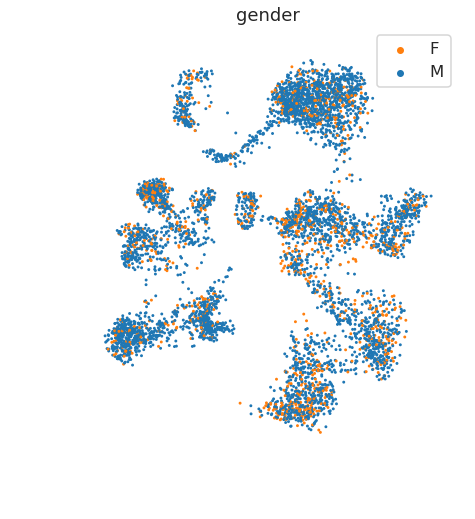

In [86]:
sample_n = 20000

fig, ax = plt.subplots(1, 1, figsize=(8*1,8*1))
# kw_colors = {settings[mod].name: settings[mod].color for mod in mods_selected}
tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'gender'
legend_kws = {'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
snmcseq_utils.plot_tsne_labels_ax(extra_meta.join(df_info)[[tx, ty, tc]].dropna(axis=0), ax, tx, ty, tc, 
#                                   legend_kws=legend_kws,
                                  sample_n=sample_n,
                                  legend_size=30,
                                  rasterized=True,
                                  s=2,
                                 )
ax.set_aspect('equal')
ax.axis('off')

# fig.savefig(output_figures.format('sex', 'pdf'), bbox_inches='tight', dpi=300)
plt.show()



In [89]:
extra_meta = metas['snmcseq_gene']

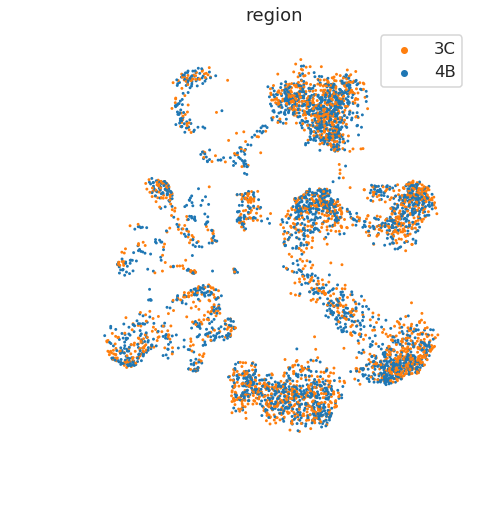

In [90]:
sample_n = 20000

fig, ax = plt.subplots(1, 1, figsize=(8*1,8*1))
# kw_colors = {settings[mod].name: settings[mod].color for mod in mods_selected}
tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'region'
legend_kws = {'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
snmcseq_utils.plot_tsne_labels_ax(extra_meta.join(df_info)[[tx, ty, tc]].dropna(axis=0), ax, tx, ty, tc, 
#                                   legend_kws=legend_kws,
                                  sample_n=sample_n,
                                  legend_size=30,
                                  rasterized=True,
                                  s=2,
                                 )
ax.set_aspect('equal')
ax.axis('off')

# fig.savefig(output_figures.format('sex', 'pdf'), bbox_inches='tight', dpi=300)
plt.show()

